In [5]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
command_train = None

**Experimental methods**

Our goal is to find out how the performance of models change as they get more difficult to simulate classically. Under the divide and conquer scheme we cut two-qubit gates in order to partition a model into blocks containing fewer qubits. The scaling of the resulting algorithm is as follows: $\mathcal{O}(2^{K+n}B)$, where $K$ is the number of two-qubit gates that are cut, $n$ the number of qubits in the largest block and $B$ the number of blocks. In order to avoid having to solve the combinatorially hard task of finding the optimal cuts for any arbitrary circuit, we predefine a circuit with a set number of blocks, each with the same number of qubits, and introduce the cut two-qubit gates as a design choice. This allows for a more refined control of the difficulty of the simulation. From the scaling it is evident that simulatability is mainly a tradeoff between the number of cut gates, and the number of qubits in each block. 
In the remainder of this notebook we go through important experiment design choices, and justify our decisions for each.


*Number of blocks $B$, qubits $n$ and cuts $K$* <br>
In order to maintain the possibility of full qubit connectivity/entanglement (such as in Fig 1), it is reasonable to generally relate the number of cut gates to the number of blocks. For example, in order to achieve a ring of qubit connectivity, one would need as many cut gates as blocks, ie $K=B$. As long as we make this demand, this is a restriction on the number of blocks as $K$ contributes to the exponential scaling. We would like to use our D&C method to go beyond the limits of brute force full circuit simulation, which we can set at 15 qubits as a conservative estimate, such that we want $Bn\ge15$. <br>
During testing we find the upper limit of the hardware to be around $(K=8, n=5) $ or $ (K=0, n=12)$. *We choose to fix $n=5$* for most experiments as this allows for a good range of $K$'s to be tested. We vary $B$ as desired, but aim to set it at 4 for the final experiments such that we end up with a 20 qubit classifier, which is larger than most models seen in related literature.

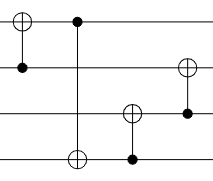
<br> Fig 1. An example of a ring of CNOTs leading to full qubit entanglement.

*Block ansatz* <br>
We elect to go with a hardware efficient ansatz as the gate set is native to many NISQ devices (A. Kandala et al., Nature, 2017). A circuit diagrammatic representation is shown below in Fig 2. It can readily be generalized to $n$ qubits, and the gates highlighted in the blue box can be repeated for multiple "layers", before the last set of single qubit rotations. These are arbitrary rotations, implemented as $R_{z}(\alpha_{j})R_{y}(\beta_{j})R_{z}(\gamma_{j})$. We assign each data point one qubit and vice versa. These are uploaded through a parameterized $R_{x}$ gate. We use parameterized $R_{z}$ and $R_{y}$ gates to introduce as these do not commute with the data uploading gates. The qubits are entangled using the CNOT gate, which has no free parameters. For convenience let us define $U_{l}(\theta, x)$ as the $l$th repetition of the gates in the blue box below. The action of our block ansatz with $L$ layers can be expressed as $W^{L}(\Theta, x)|\psi\rangle=V(\prod_{i}^{L}U_{i}(\theta_{i},x))|\psi\rangle$ where $V$ is the unitary containing the single qubit rotations preceding the measurement, $|\psi\rangle$ some fiducial state and $\bigcup_{i}\theta_{i} = \Theta \in [-\pi/2, \pi/2]^{N_{P}}$, with $N_{P}=3(L+1)n$ is the total number of parameters per block. 

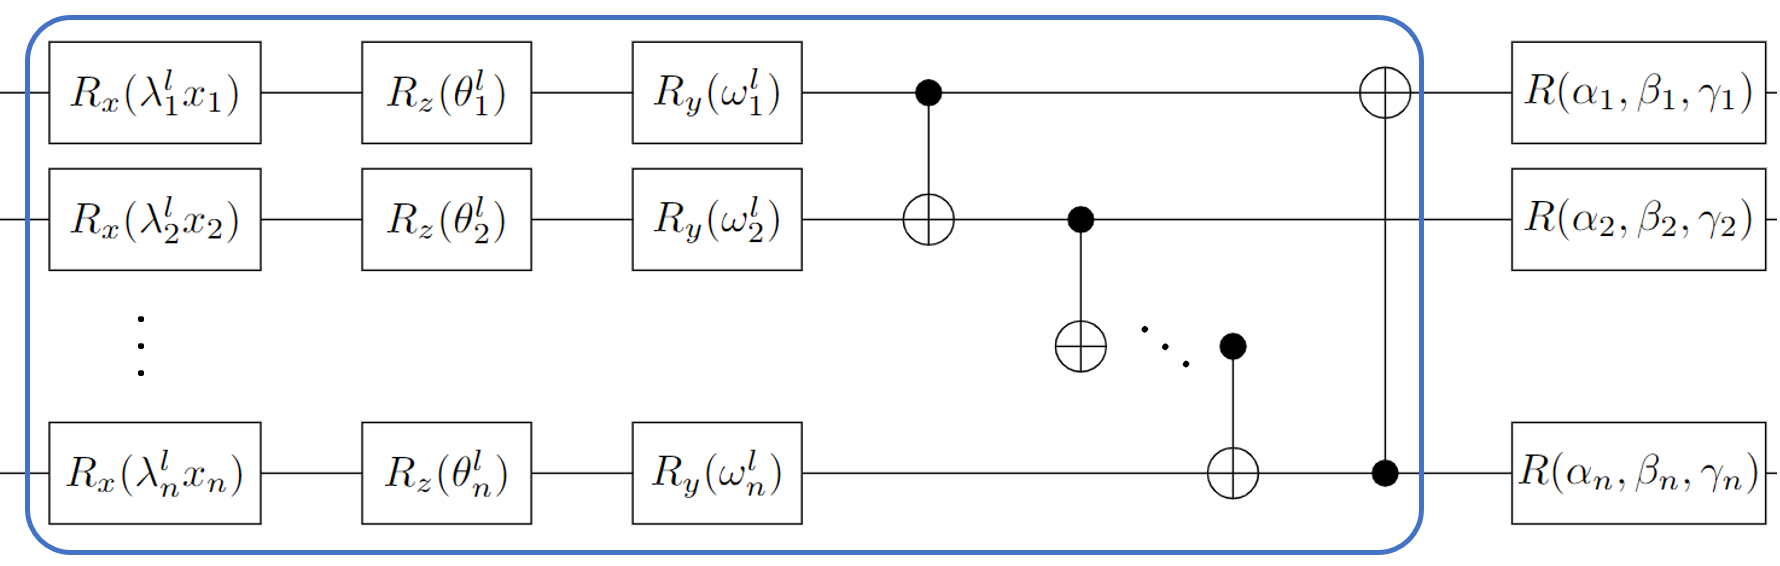
Fig 2. The Hardware Efficient Ansatz (HEA) used in this report. The gates in the blue box can be repeated multiple times for increased expressivity. Here the subscripts identify the qubit and the superscript the layer in which a certain parameter appears.

*Circuit Ansatz* <br>
The overall circuit ansatz is a contructed from the block ansatz, the CNOTs connecting the blocks and an obervable. 
Starting with the CNOTs connecting blocks, we highlight our method of placement in Fig 3 below. Each qubit line now represents one block of $n$ qubits as in Fig 2, within which two-qubit gates do not cost any additional resources. Each CNOT (acting across block partitions) has the last qubit in the control block as the control qubit, and the first qubit in the target block is the target qubit. Since the intra-block CNOTs act before the inter-block CNOTs, the structure is not exactly ring like, and only for $L>1$ gives full qubit connectivity. Our choice of observable is Pauli-Z. We empirically test the difference between a Pauli-Z on all-qubits, and on the last qubit of each block below.

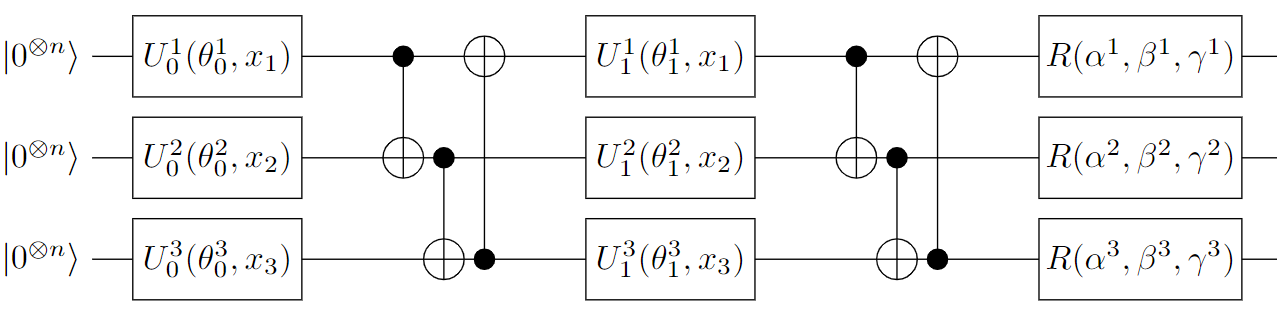
Fig 3. Circuit diagram of the model used in this report, with 2 layers and $K=6$ cut CNOTs. Each $U^{P_{i}}_{l}$ is one layer as shown in the blue box in Fig 2. The CNOTs displayed are simulated using the gate cutting technique. Here the superscripts identify the partition the unitary acts on and the subscript the layer index.

We first show plots of the training and validation accuracy to assess convergence or overfitting. Later we will better present the differences.
All


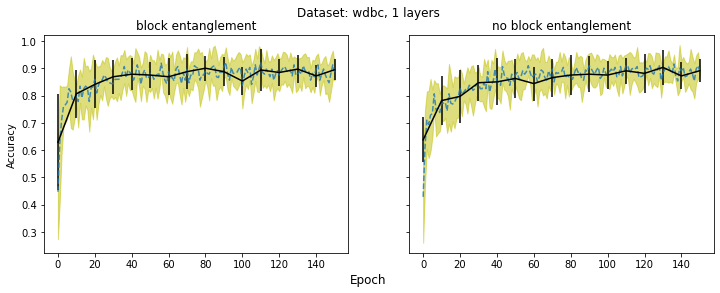

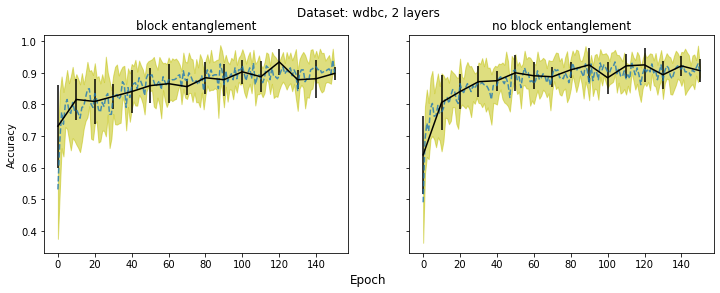

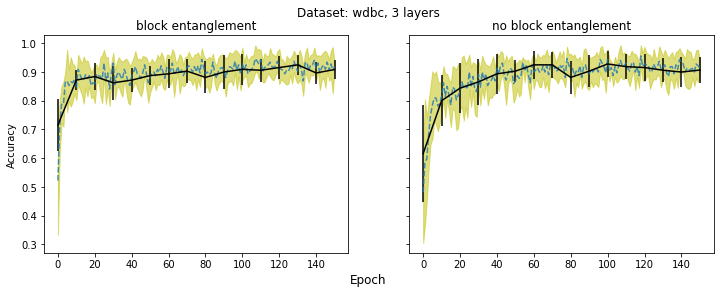

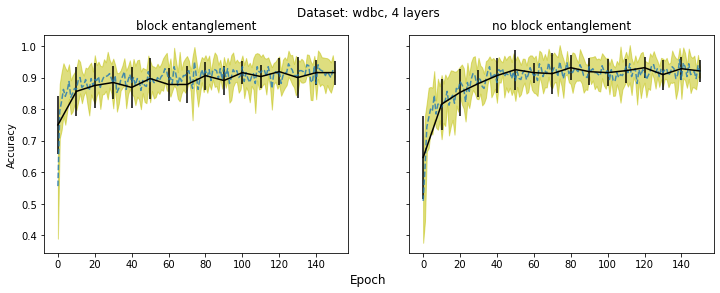

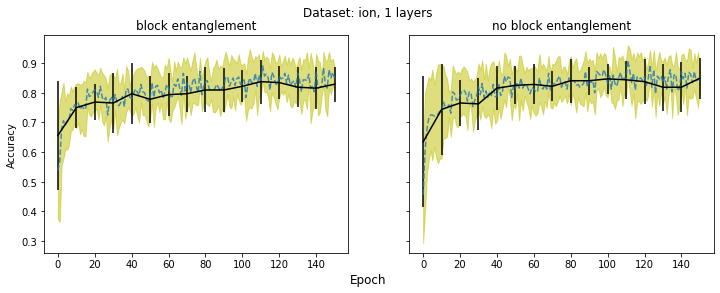

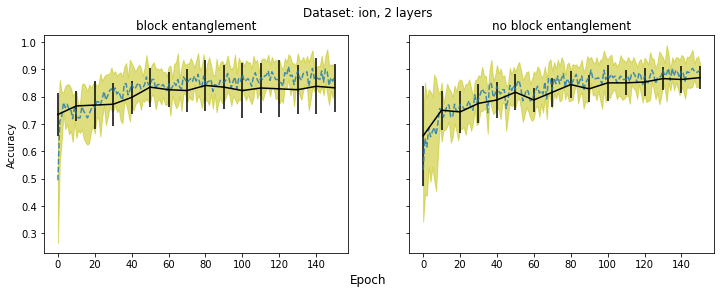

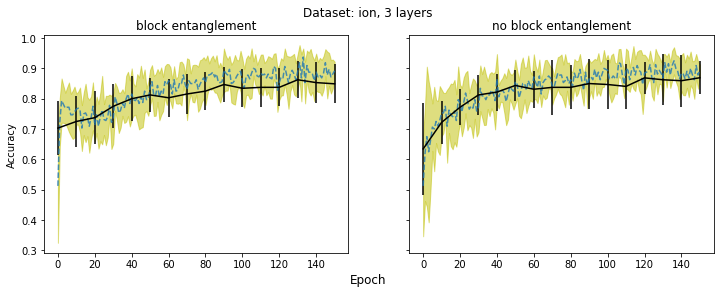

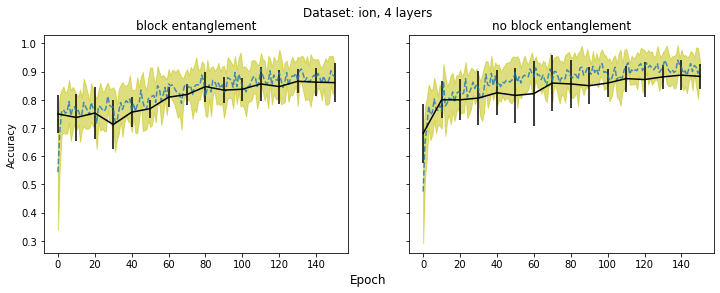

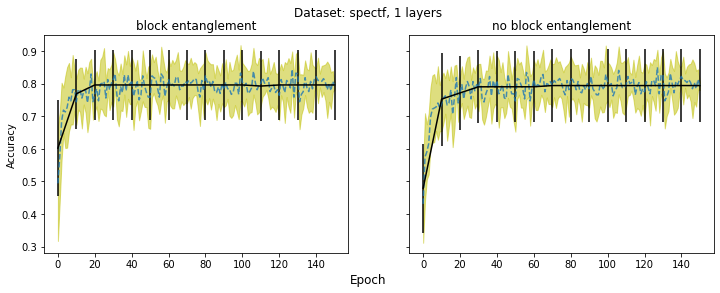

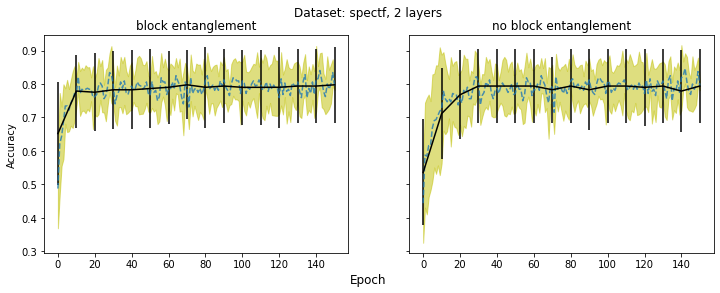

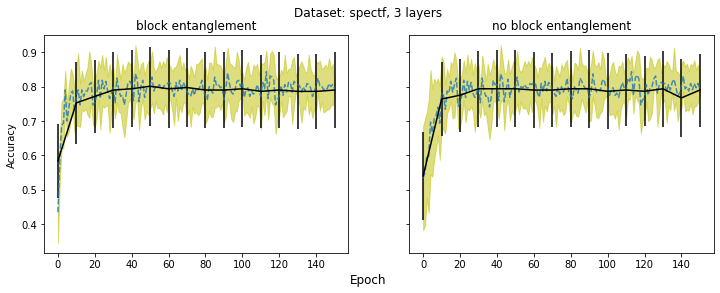

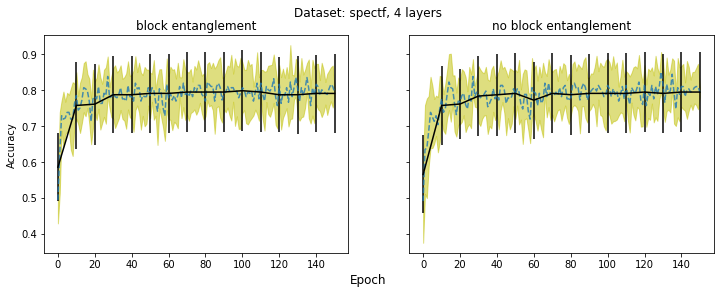

First


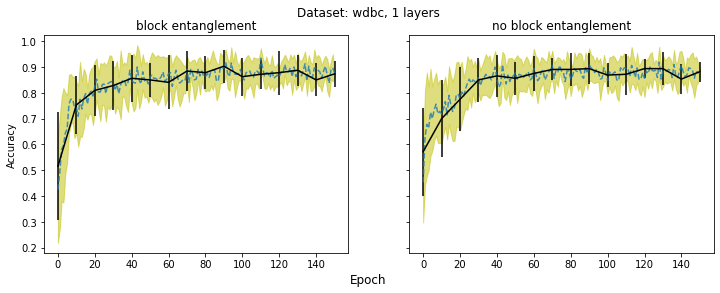

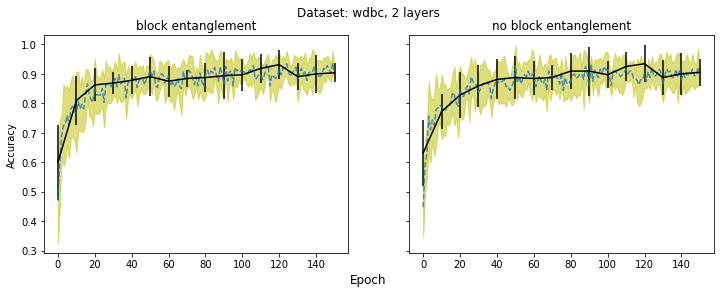

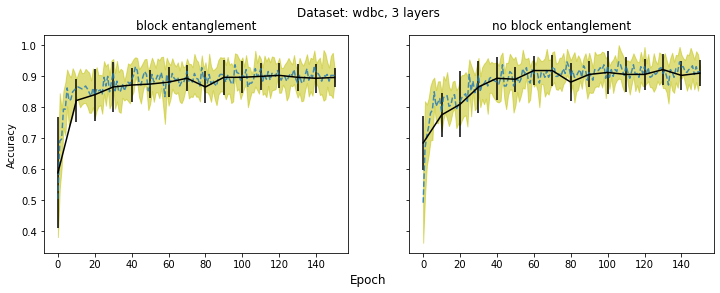

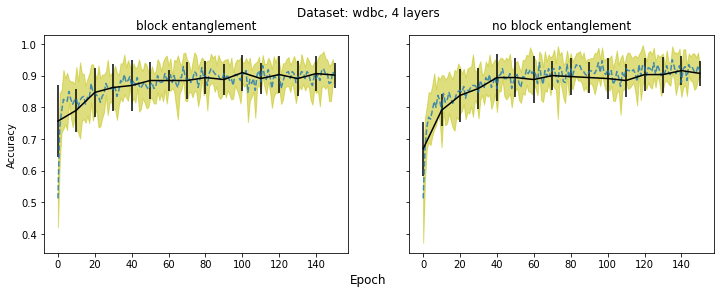

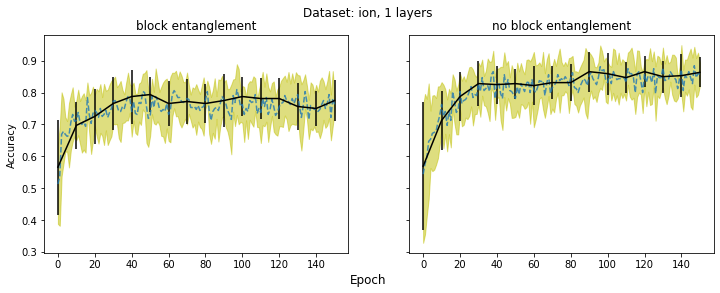

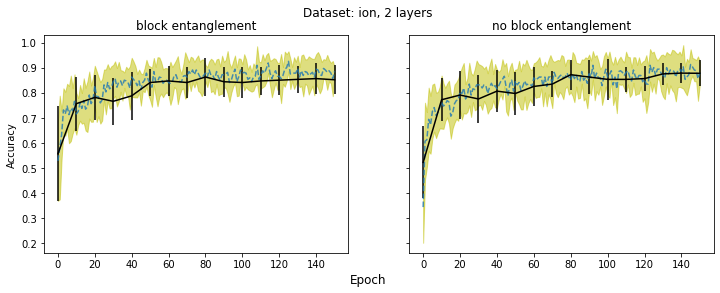

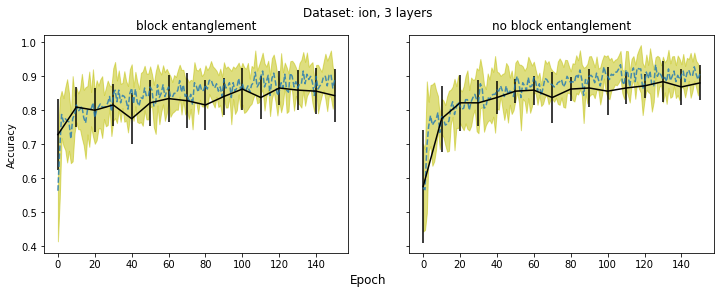

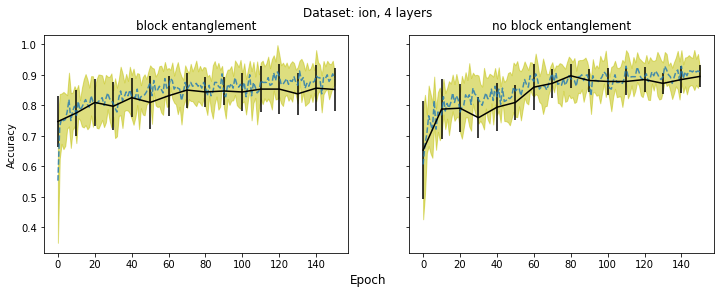

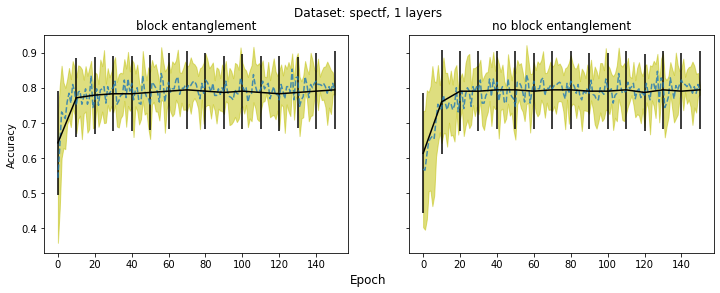

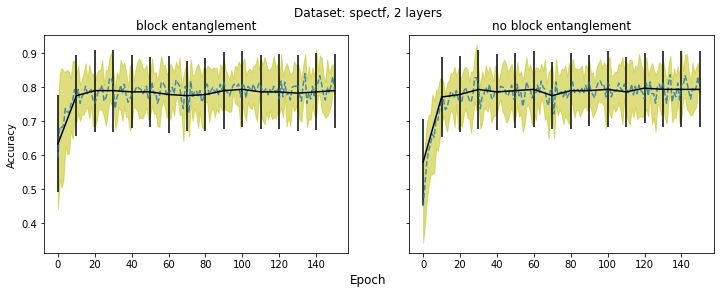

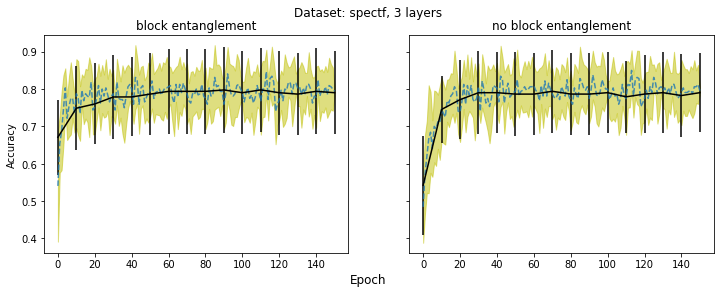

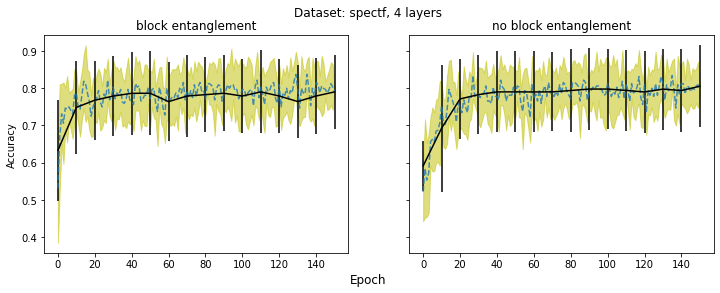

0,0


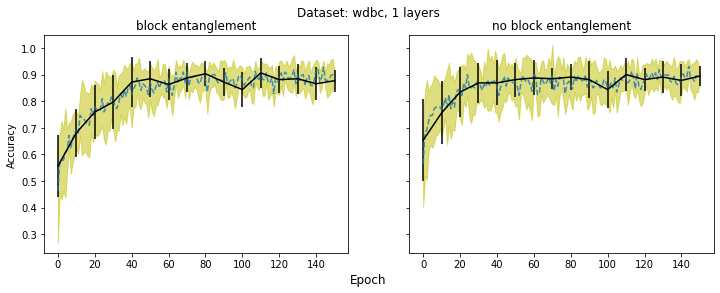

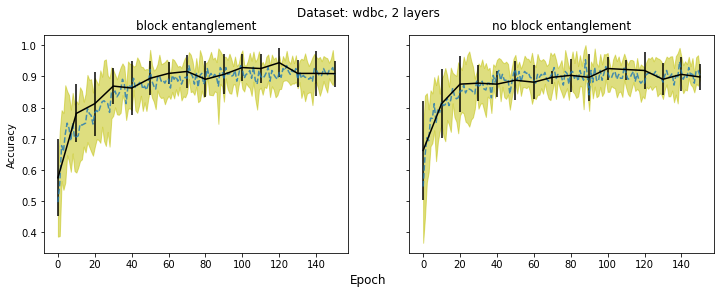

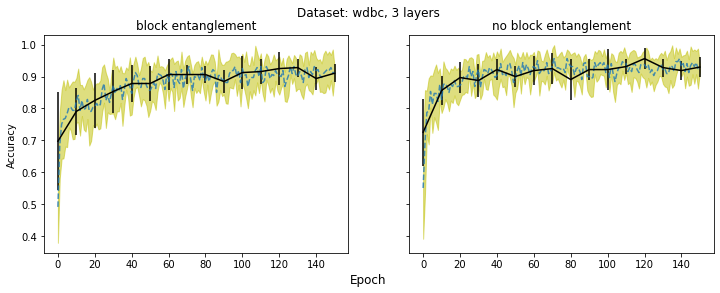

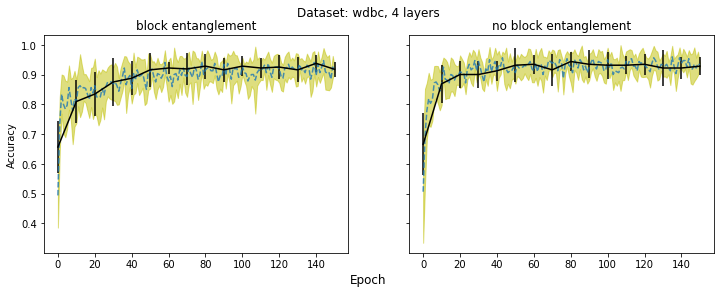

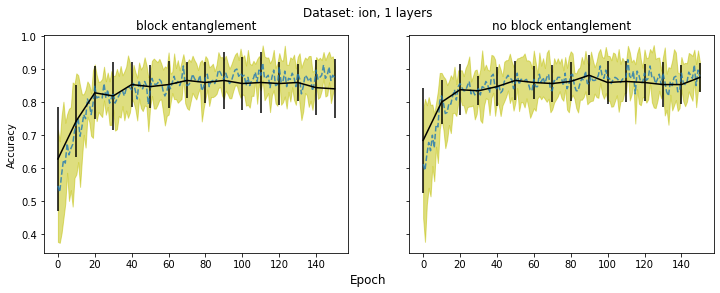

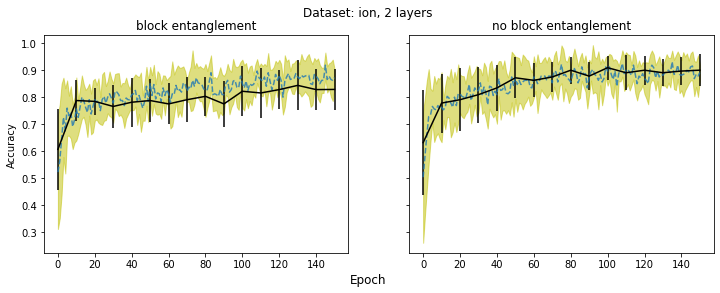

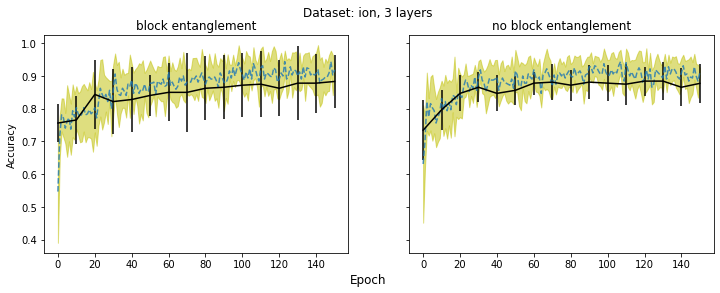

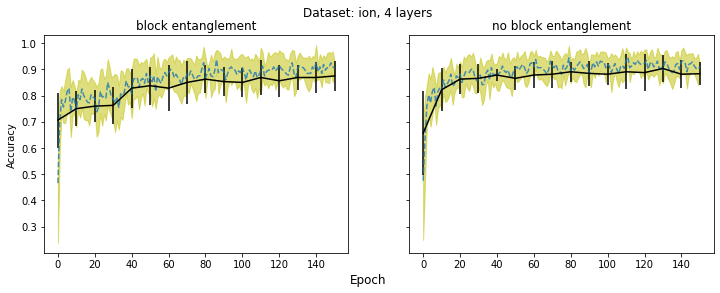

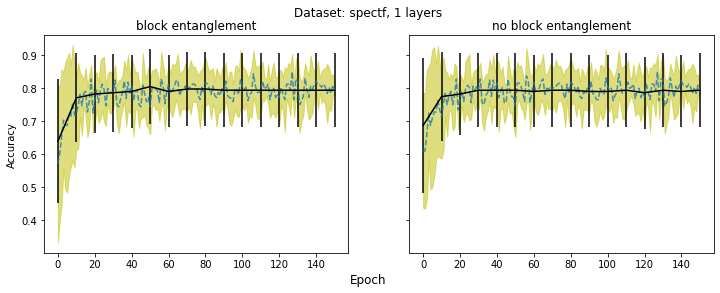

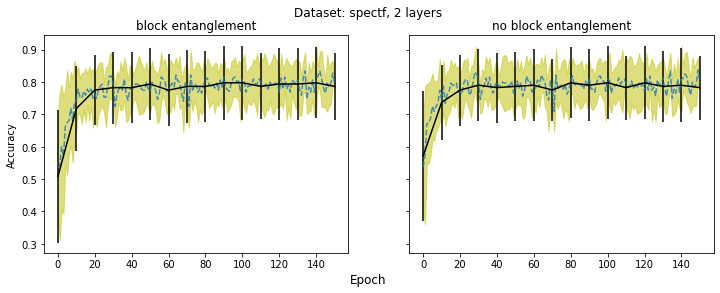

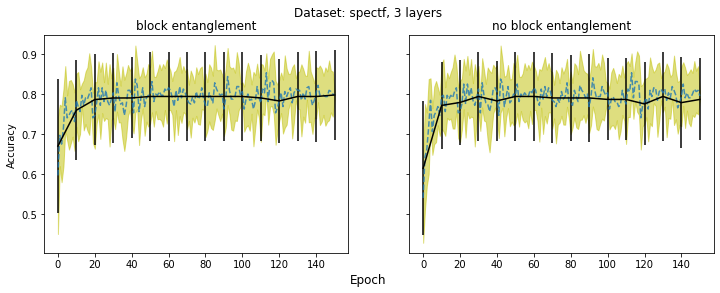

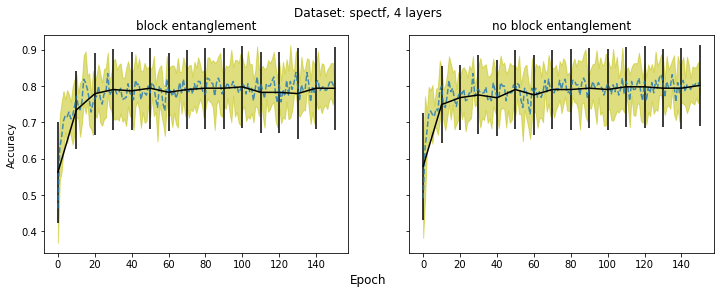

In [4]:
datasets = ["wdbc", "ion", "spectf"]
colors = ["b", "g", "r", "k"]
obs = ["All", "First", "0,0"]
models = ["PQC-4B", "PQC-4C"]

 
def label_ent(mod):
    if mod[-1] == "B":
        return "block entanglement"
    else:
        return "no block entanglement"

print("We first show plots of the training and validation accuracy to assess convergence or overfitting." \
     " Later we will better present the differences.")
command_train = None

v_x_range = np.arange(0,151, 10)
t_x_range = np.arange(0,151)
#b, q fixed, l is over range [2,3,4]
for o in obs:
    print(o)
    for d in datasets:
        for l in range(1,5):
            fig1, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
            fig1.suptitle(f"Dataset: {d}, {l} layers")
            ax[0].set_ylabel("Accuracy")
            fig1.supxlabel("Epoch")
            for j, m in enumerate(models):
                v_acc_mean, v_acc_std = [], []
                t_acc_mean, t_acc_std = [], []
                fname = f"runs/Exp15*{d}*{m}-{l}-2-5-{o}*.pkl"
                files = glob.glob(fname)
                if len(files) >= 1:
                    v_accs = np.zeros((len(files), 16))
                    t_accs = np.zeros((len(files), 151))
                    for i, f in enumerate(files):
                        pickle_open = open(f, 'rb')
                        run_dict = pickle.load(pickle_open)
                        v_accs[i] = run_dict["validation_accuracy"]
                        t_accs[i] = run_dict["training_acc"]
                    ax[j].set_title(f"{label_ent(m)}")
                    ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
                    #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
                    ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
                    ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
            plt.show()
        


In [3]:
datasets = ["wdbc", "ion", "spectf"]
models = ["PQC-4B", "PQC-4C"]
obs = ["All", "First", "0,0"]

import pandas as pd

command_train = None

obs_diff, ent_diff = [], []

for d in datasets:
    Ent, Obs, val1, val2, val3, val4 = [],[],[],[],[],[]
    std1, std2, std3, std4 = [],[],[],[]
    for j, o in enumerate(obs):
        for k, m in enumerate(models):
            if m == "PQC-4B":
                E = True
            else:
                E = False
            Ent.append(E)
            Obs.append(o)
            for l in range(1,5):
                fname = f"runs/Exp15*{d}*{m}-{l}-2-5-{o}*.pkl"
                files = glob.glob(fname)
                v_accs = np.zeros((len(files), 1))
                t_accs = np.zeros((len(files), 1))
                if len(files) >= 1:
                    for i, f in enumerate(files):
                        pickle_open = open(f, 'rb')
                        run_dict = pickle.load(pickle_open)
                        v_accs[i] = run_dict["validation_accuracy"][-1]
                        t_accs[i] = run_dict["training_acc"][-1] 


                if l==1: 
                    val1.append(np.mean(v_accs))
                    std1.append(np.std(v_accs))
                if l==2: 
                    val2.append(np.mean(v_accs))
                    std2.append(np.std(v_accs))
                if l==3: 
                    val3.append(np.mean(v_accs))
                    std3.append(np.std(v_accs))
                if l==4: 
                    val4.append(np.mean(v_accs))
                    std4.append(np.std(v_accs))
                
    print(f"{d} dataset")
    display(pd.DataFrame({"Interblock CNOTs": Ent, "Observable": Obs, 
              "Val Acc L=1": val1, "Std1": std1, "Val Acc L=2": val2, "Std2": std2, "Val Acc L=3": val3, "Std3": std3, "Val Acc L=4": val4, "Std4": std4})
         )

wdbc dataset


Interblock CNOTs Observable  Val Acc L=1      Std1  Val Acc L=2      Std2  \
0              True        All     0.894612  0.037512     0.898026  0.020694   
1             False        All     0.890977  0.041565     0.906798  0.036184   
2              True      First     0.873434  0.050801     0.903446  0.032469   
3             False      First     0.882174  0.038780     0.905075  0.046595   
4              True        0,0     0.877036  0.041386     0.908647  0.041306   
5             False        0,0     0.894643  0.036667     0.897932  0.040438   

   Val Acc L=3      Std3  Val Acc L=4      Std4  
0     0.908678  0.032047     0.915664  0.038232  
1     0.906830  0.045160     0.920927  0.033487  
2     0.896366  0.031692     0.901566  0.039423  
3     0.910338  0.041183     0.906924  0.039951  
4     0.910401  0.027599     0.917450  0.025975  
5     0.929731  0.031332     0.927945  0.029820

ion dataset


Interblock CNOTs Observable  Val Acc L=1      Std1  Val Acc L=2      Std2  \
0              True        All     0.828889  0.058871     0.831984  0.088758   
1             False        All     0.849127  0.068496     0.869048  0.042338   
2              True      First     0.774921  0.065714     0.851587  0.058525   
3             False      First     0.863413  0.046755     0.877381  0.051367   
4              True        0,0     0.840238  0.088912     0.828730  0.076903   
5             False        0,0     0.874603  0.042857     0.900159  0.060386   

   Val Acc L=3      Std3  Val Acc L=4      Std4  
0     0.849127  0.064822     0.860873  0.069550  
1     0.869127  0.053833     0.883175  0.043268  
2     0.843175  0.079202     0.851905  0.071917  
3     0.880556  0.051544     0.894603  0.036190  
4     0.883254  0.081149     0.874683  0.055879  
5     0.877460  0.060053     0.883175  0.043268

spectf dataset


Interblock CNOTs Observable  Val Acc L=1      Std1  Val Acc L=2      Std2  \
0              True        All     0.795908  0.106548     0.797721  0.112809   
1             False        All     0.794017  0.111573     0.794017  0.111573   
2              True      First     0.794017  0.110336     0.790313  0.108946   
3             False      First     0.794017  0.111573     0.794017  0.111573   
4              True        0,0     0.794017  0.111573     0.786610  0.103507   
5             False        0,0     0.794017  0.111573     0.782906  0.099021   

   Val Acc L=3      Std3  Val Acc L=4      Std4  
0     0.790313  0.111435     0.790171  0.110365  
1     0.790313  0.106398     0.794017  0.111573  
2     0.790171  0.111698     0.790313  0.099743  
3     0.790313  0.106398     0.805413  0.110582  
4     0.797721  0.112809     0.793732  0.114432  
5     0.786610  0.102173     0.801567  0.111104

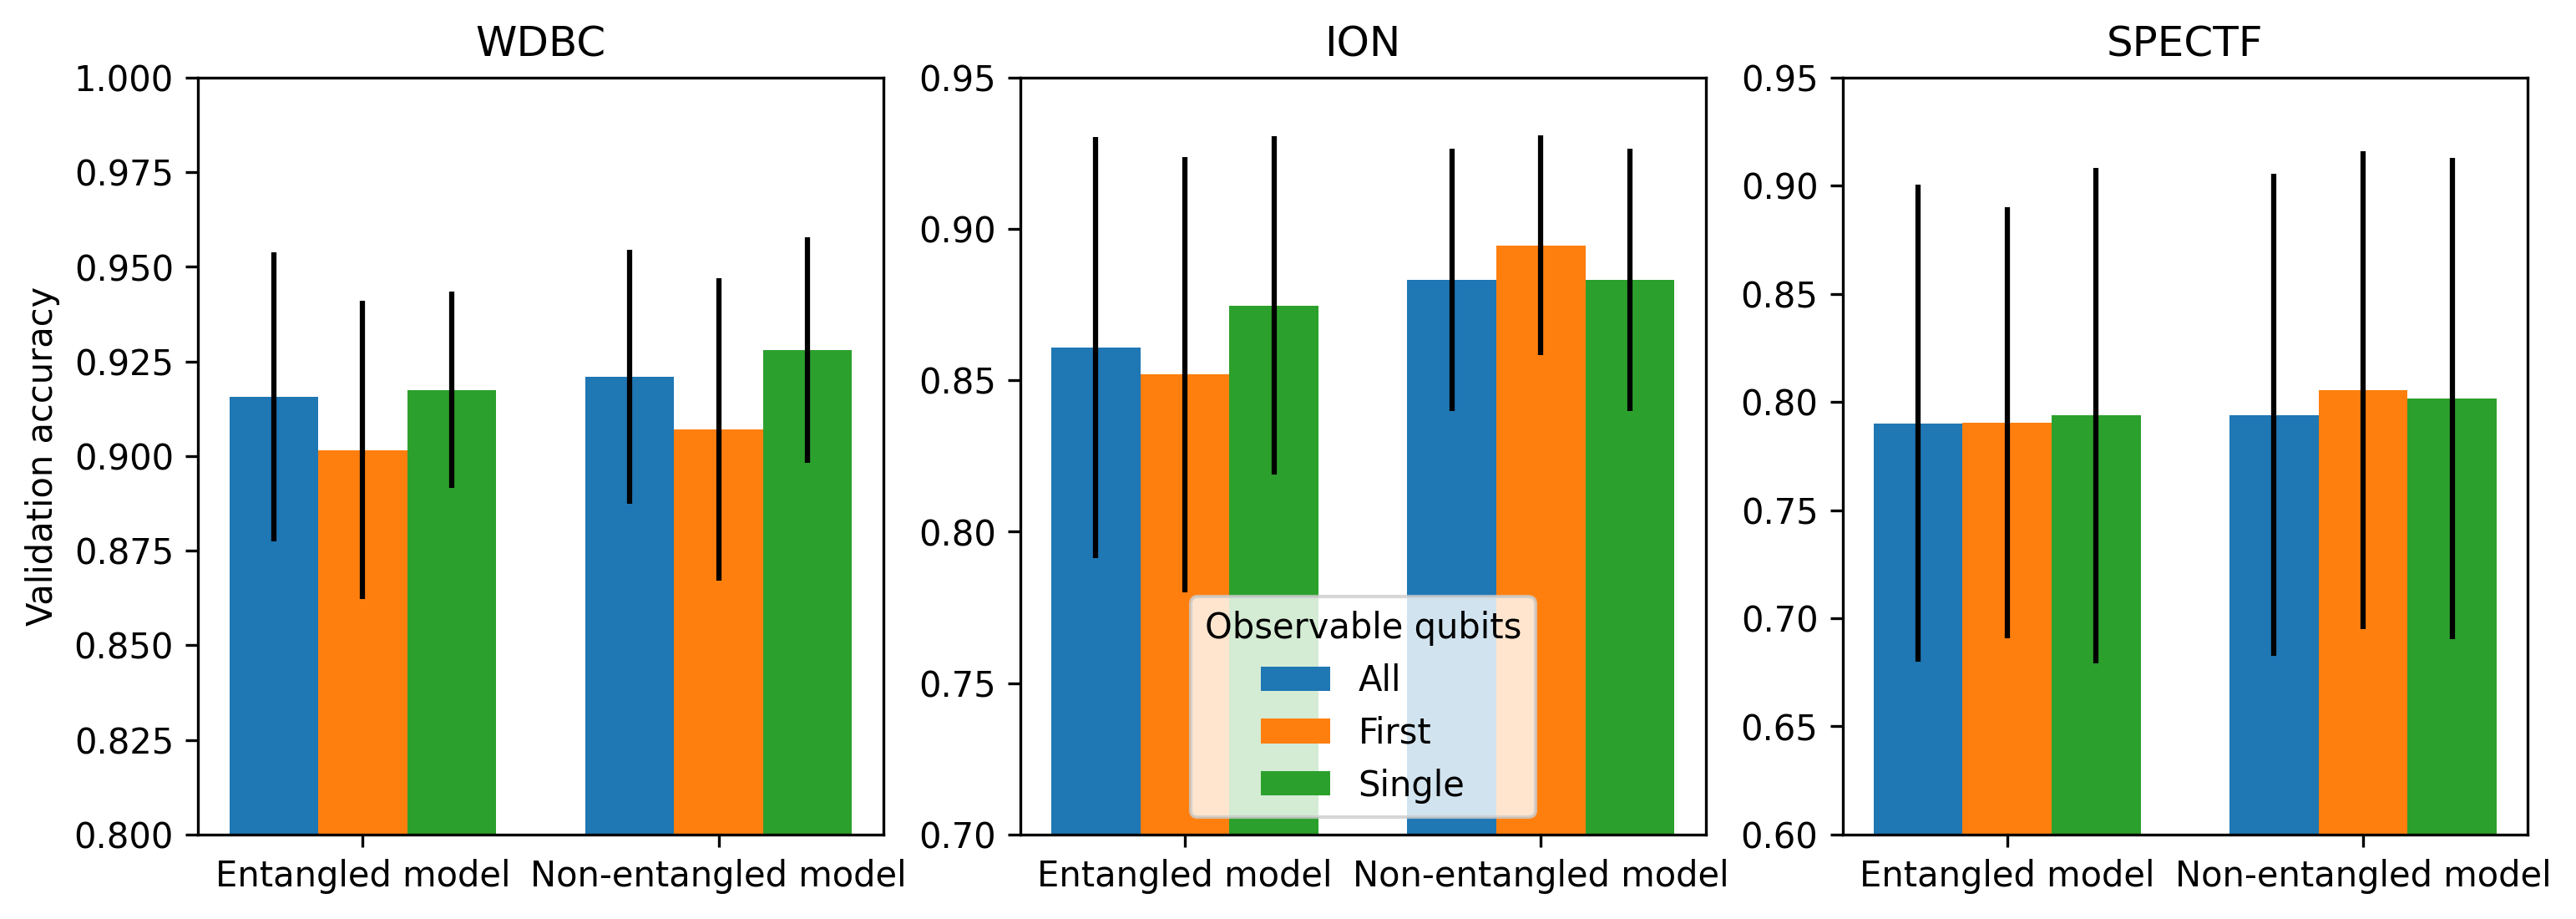

In [12]:
datasets = ["wdbc", "ion", "spectf"]
Dnames = ["WDBC", "ION", "SPECTF"]
models = ["PQC-4B", "PQC-4C"]
obs = ["All", "First", "0,0"]
OBS = ["All", "First", "Single"]
linetypes = ["-", "--"]
cls = ["g", "b", "r"]
caps = ["Entangled model", "Non-entangled model"]

import pandas as pd

command_train = None
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=300)
plt.setp(ax, xticks=1.6*np.arange(2), xticklabels=caps)
for q,d in enumerate(datasets):
    for j, o in enumerate(obs):
        val1 = []
        std1 = []
        for k, m in enumerate(models):
            fname = f"runs/Exp15*{d}*{m}-4-2-5-{o}*.pkl"
            files = glob.glob(fname)
            v_accs = np.zeros((len(files), 1))
            t_accs = np.zeros((len(files), 1))
            if len(files) >= 1:
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    v_accs[i] = run_dict["validation_accuracy"][-1]
                    t_accs[i] = run_dict["training_acc"][-1] 

            val1.append(np.mean(v_accs))
            std1.append(np.std(v_accs))
        ax[q].bar(1.6*np.arange(2)+(j-1)*0.4, val1, 0.4, label=f"{OBS[j]}", yerr=std1)
        
    ax[0].set_ylabel("Validation accuracy")
    ax[q].set_title(f"{Dnames[q]}")
    if q == 0:
        ax[q].set_ylim(0.8,1)
    if q == 1:
        ax[q].set_ylim(0.7,0.95)
    if q == 2:
        ax[q].set_ylim(0.6,0.95)
ax[1].legend(loc="lower center", title=r"Observable qubits")
plt.show()
                


From the tables above we can make the following conclusions:
1) For the breast cancer dataset the choice of interblock and observable is insignificant. Adding more layers improves performance.

2) For the ionosphere dataset, the absence of interblock CNOTs improves performance.

3) (SPECTF) Very difficult to distinguish differences in performance due to any of the variables.

As there is no empirical difference between the observables, we repeat the experiment on some artificial dataset. The data label is the output of our circuit ansatz with two blocks of five qubits, 2 layers, randomly initialized parameters and input vectors sampled from the uniform distribution [-$\pi$, $\pi$].

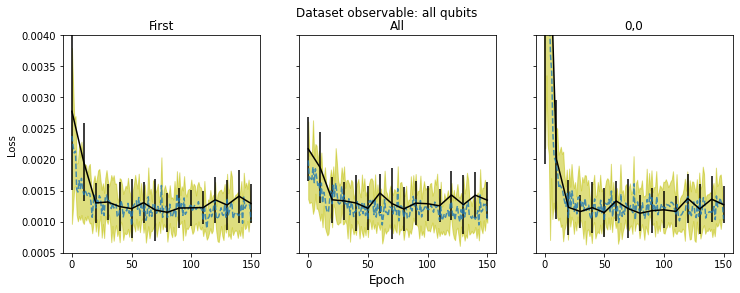

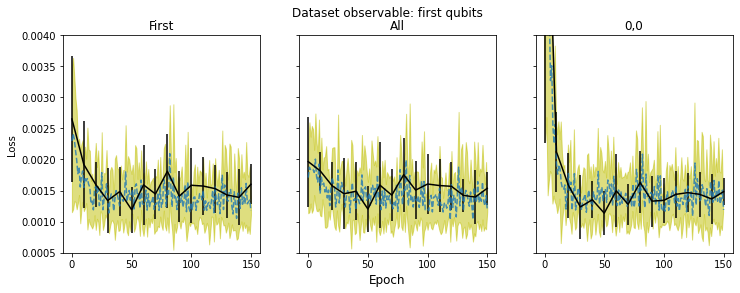

In [4]:
datasets = ["synth-4A", "synth-4F"]
observs = ["First", "All", "0,0"]
command_train = None

def data_label(dataset):
    if dataset == "synth-4A":
        return "all qubits"
    elif dataset == "synth-4F":
        return "first qubits"

v_x_range = np.arange(0,151, 10)#np.arange(10,151, 10)
t_x_range = np.arange(0,151)#np.arange(10,151)
for d in datasets:
    fig1, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
    fig1.suptitle(f"Dataset observable: {data_label(d)}")
    ax[0].set_ylabel("Loss")
    fig1.supxlabel("Epoch")
    if d == "synth-4A":
        ax[0].set_ylim(5e-4, 0.004)
    if d == "synth-4F":
        ax[0].set_ylim(5e-4, 0.004)
    for j, o in enumerate(observs):
        v_acc_mean, v_acc_std = [], []
        t_acc_mean, t_acc_std = [], []
        fname = f"runs/Exp17*{d}-*PQC-4A-2-2-5-{o}*.pkl"
        files = glob.glob(fname)
        if len(files) >= 1:
            v_accs = np.zeros((len(files), 16))
            t_accs = np.zeros((len(files), 151))
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_loss"]#[1:]
                t_accs[i] = run_dict["training_loss"]#[10:]
            ax[j].set_title(f"{o}")
            ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
            #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
            ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
            ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), 
                               np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
    plt.show()

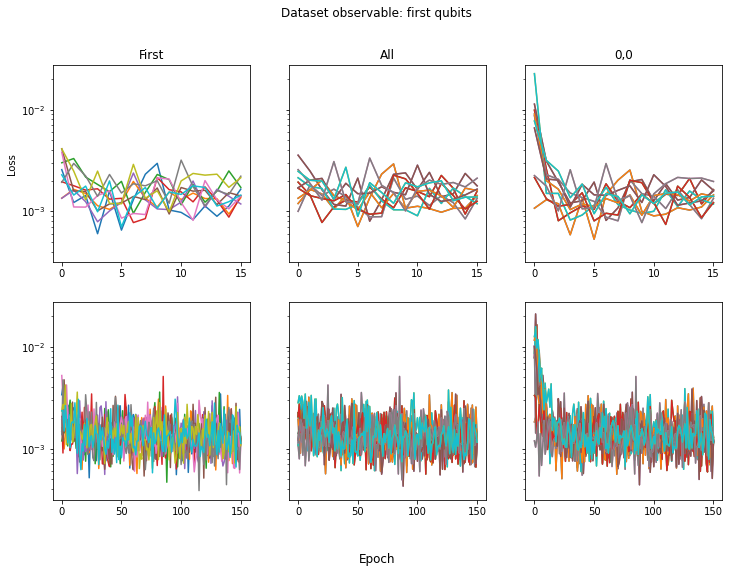

In [88]:
datasets = ["synth-4F"]
observs = ["First", "All", "0,0"]
command_train = None

def data_label(dataset):
    if dataset == "synth-4A":
        return "all qubits"
    elif dataset == "synth-4F":
        return "first qubits"

v_x_range = np.arange(0,151, 10)#np.arange(10,151, 10)
t_x_range = np.arange(0,151)#np.arange(10,151)
for d in datasets:
    fig1, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))
    fig1.suptitle(f"Dataset observable: {data_label(d)}")
    ax[0,0].set_ylabel("Loss")
    fig1.supxlabel("Epoch")
    for j, o in enumerate(observs):
        v_acc_mean, v_acc_std = [], []
        t_acc_mean, t_acc_std = [], []
        fname = f"runs/Exp17*{d}-*PQC-4A-2-2-5-{o}*.pkl"
        files = glob.glob(fname)
        if len(files) >= 1:
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                ax[0,j].semilogy(run_dict["validation_loss"])
                ax[1,j].semilogy(run_dict["training_loss"])
            ax[0,j].set_title(f"{o}")
    plt.show()

In [20]:
datasets = ["synth-4A", "synth-4F", "synth-4F-rand"]
observs = ["First", "All", "0,0", "Final"]
t_tab = np.zeros((3,4))
v_tab = np.zeros((3,4))
ts_tab = np.zeros((3,4))
vs_tab = np.zeros((3,4))
g_tab = np.zeros((3,4))
gs_tab = np.zeros((3,4))

for p, d in enumerate(datasets):
    for q, o in enumerate(observs):
        fname = f"runs/Exp17*{d}-adam-*-PQC-4A-2-2-5-{o}*.pkl"
        files = glob.glob(fname)
        print(len(files))
        if len(files) > 0:
            v_accs = np.zeros((len(files), 1))
            t_accs = np.zeros((len(files), 1))
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_loss"][-1]
                t_accs[i] = run_dict["training_loss"][-1]
            t_tab[p,q] = np.mean(t_accs)
            v_tab[p,q] = np.mean(v_accs)
            ts_tab[p,q] = np.std(t_accs)
            vs_tab[p,q] = np.std(v_accs)
            g_tab[p,q] = np.mean(v_accs-t_accs)
            gs_tab[p,q] = np.std(v_accs-t_accs)
            
t_tab *= 1000
v_tab *= 1000
ts_tab *= 1000
vs_tab *= 1000
g_tab *= 1000
gs_tab *= 1000



df = pd.DataFrame({"First":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(t_tab[0], ts_tab[0])],
                   "All":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(t_tab[1], ts_tab[1])],
                  "Random":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(t_tab[2], ts_tab[2])]
                  },
                  index=["First", "All", "Single", "Final"])

df2 = pd.DataFrame({"First":"1.282$\pm$0.079", "All":"1.128$\pm$0.079"}, index=["Neural Network"]) 
df = df.append(df2)
df.columns.name = 'Dataset observable qubits'
df.index.name = 'Model observable qubits'
print(f"Training loss x 1000")
display(df)


df = pd.DataFrame({"First":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(v_tab[0], vs_tab[0])],
                   "All":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(v_tab[1], vs_tab[1])],
                  "Random":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(v_tab[2], vs_tab[2])]
                  },
                  index=["First", "All", "Single", "Final"])

df2 = pd.DataFrame({"First": "1.532$\pm$0.196", "All": "1.308$\pm$0.209"}, index=["Neural Network"]) 
df = df.append(df2)
df.columns.name = 'Dataset observable qubits'
df.index.name = 'Model observable qubits'

print(f"Validation loss x 1000")
display(df)


df = pd.DataFrame({"First":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(g_tab[0], gs_tab[0])],
                   "All":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(g_tab[1], gs_tab[1])],
                  "Random":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(g_tab[2], gs_tab[2])]
                  },
                  index=["First", "All", "Single", "Final"])

df.columns.name = 'Dataset observable qubits'
df.index.name = 'Model observable qubits'

print(f"Generalization loss x 1000")
display(df)
          
        


10
10
10
10
40
10
10
40
30
30
30
30
Training loss x 1000


Dataset observable qubits            First              All           Random
Model observable qubits                                                     
First                      1.018$\pm$0.023  1.203$\pm$0.059  1.425$\pm$0.094
All                        1.014$\pm$0.032  1.190$\pm$0.025  1.428$\pm$0.080
Single                     1.038$\pm$0.022  1.189$\pm$0.045  1.414$\pm$0.083
Final                      1.025$\pm$0.033  1.209$\pm$0.061  1.427$\pm$0.069
Neural Network             1.282$\pm$0.079  1.128$\pm$0.079              NaN

Validation loss x 1000


Dataset observable qubits            First              All           Random
Model observable qubits                                                     
First                      1.293$\pm$0.311  1.491$\pm$0.335  1.480$\pm$0.230
All                        1.345$\pm$0.294  1.537$\pm$0.263  1.493$\pm$0.242
Single                     1.273$\pm$0.295  1.483$\pm$0.219  1.453$\pm$0.229
Final                      1.329$\pm$0.273  1.500$\pm$0.324  1.481$\pm$0.258
Neural Network             1.532$\pm$0.196  1.308$\pm$0.209              NaN

Generalization loss x 1000


Dataset observable qubits            First              All           Random
Model observable qubits                                                     
First                      0.275$\pm$0.318  0.288$\pm$0.370  0.055$\pm$0.259
All                        0.331$\pm$0.315  0.346$\pm$0.257  0.064$\pm$0.264
Single                     0.235$\pm$0.305  0.294$\pm$0.222  0.039$\pm$0.262
Final                      0.305$\pm$0.284  0.292$\pm$0.363  0.054$\pm$0.294

The variance of the dataset targets is around 1.15e-3 and 1.07e-3 for the First and All qubit observables respectively. Since these are roughly equal to the training losses above, it suggests the models are only capable of learning the correct output distribution, instead of the exact mapping $X \rightarrow Y$. 

The differences between the training and validation loss suggest there is some overfitting. This observation is supported by the much larger error bars for the validation loss relative to those for the training loss.

From the above tables it is evident that the dataset with the "First" observable is easier to learn compared with the dataset generated by measuring all qubits. 
The differences between the model observable fall entirely within the error bars, however the single qubit observable achieves the best validation loss, and also generalization loss. Whilst it is trivial to understand that increasing the number of measured qubits increases the expressivity of the model, this shows it is possible for quantum models to overfit when the underlying decision function is quantum in nature. 



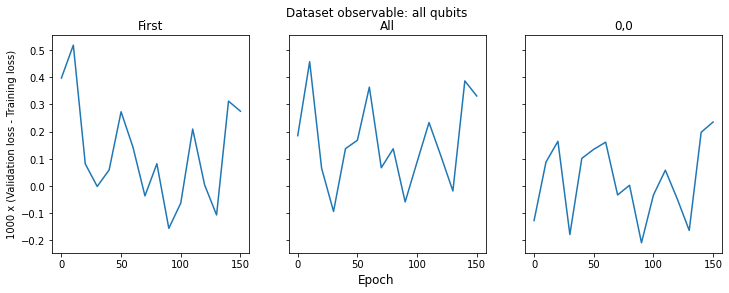

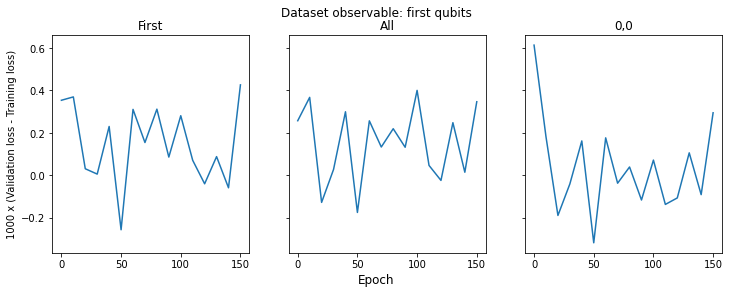

In [31]:
datasets = ["synth-4A", "synth-4F"]
observs = ["First", "All", "0,0"]
command_train = None

def data_label(dataset):
    if dataset == "synth-4A":
        return "all qubits"
    elif dataset == "synth-4F":
        return "first qubits"

v_x_range = np.arange(0,151, 10)#np.arange(10,151, 10)
t_x_range = np.arange(0,151, 10)#np.arange(10,151)
for d in datasets:
    fig1, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
    fig1.suptitle(f"Dataset observable: {data_label(d)}")
    ax[0].set_ylabel("1000 x (Validation loss - Training loss)")
    fig1.supxlabel("Epoch")
    for j, o in enumerate(observs):
        v_acc_mean, v_acc_std = [], []
        t_acc_mean, t_acc_std = [], []
        fname = f"runs/Exp17*{d}-*PQC-4A-2-2-5-{o}*.pkl"
        files = glob.glob(fname)
        if len(files) >= 1:
            v_accs = np.zeros((len(files), 16))
            t_accs = np.zeros((len(files), 16))
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_loss"]#[1:]
                t_accs[i] = run_dict["training_loss"][::10]
            ax[j].set_title(f"{o}")
            
            ax[j].plot(t_x_range, np.mean(v_accs*1000-t_accs*1000, axis=0))
    plt.show()

*Number of layers* <br>
As mentioned above, a core block of the circuit can be repeated for a certain number of layers. Each additional layer increases the expressivity of the model.  

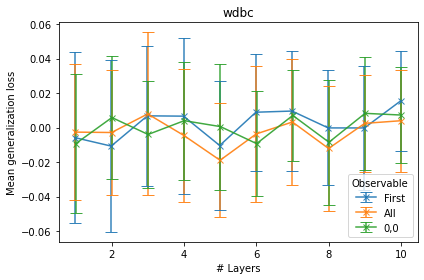

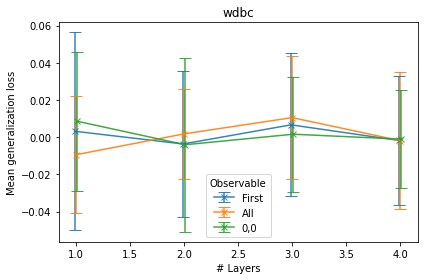

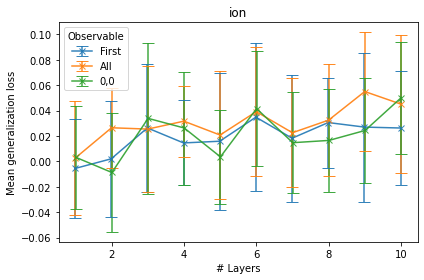

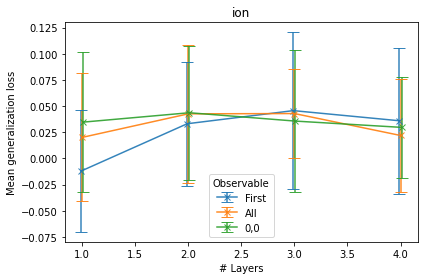

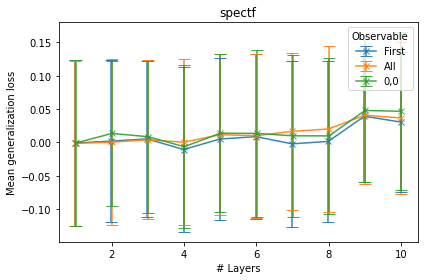

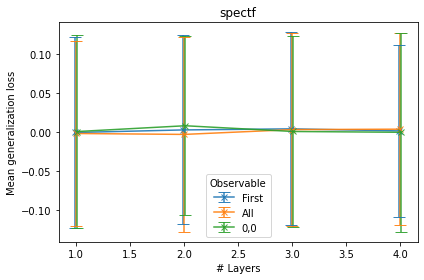

In [13]:
models = ["PQC-4C", "PQC-4B"] #Only include datareuploading models here
datasets = ["wdbc", "ion", "spectf"]
observs = ["First", "All", "0,0"]
line_types = ["--", "-."]

def mod_label(model):
    if model == "PQC-4B":
        return True
    elif model == "PQC-4C":
        return False

for d in datasets:
    for j, MOD in enumerate(models):  
        #print(MOD)
        for k, o in enumerate(observs):
            layrs_found = []
            mean_g_err = []
            mean_g_std = []
            for layer in range(1,11):
                fname = f"runs/Exp15*{d}-*{MOD}-{layer}-2-5-{o}*.pkl"
                files = glob.glob(fname)
                g_err = np.zeros((len(files)))
                if len(files) >= 1:
                    for i, f in enumerate(files):
                        pickle_open = open(f, 'rb')
                        run_dict = pickle.load(pickle_open)
                        pickle_open.close()
                        g_err[i] = run_dict["training_acc"][-1] - run_dict["validation_accuracy"][-1]

                    mean_g_std.append(np.std(g_err))
                    mean_g_err.append(np.mean(g_err))
                    layrs_found.append(layer)

            plt.errorbar(np.array(layrs_found)+(k-1)*0.01, mean_g_err, yerr=mean_g_std, fmt="x-", label=o,
                         alpha=0.9, capsize=6)

        plt.xlabel("# Layers")
        plt.ylabel("Mean generalization loss")
        plt.title(f"{d}")
        plt.tight_layout()
        plt.legend(title="Observable")

        plt.show()

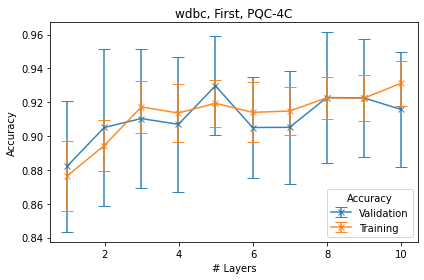

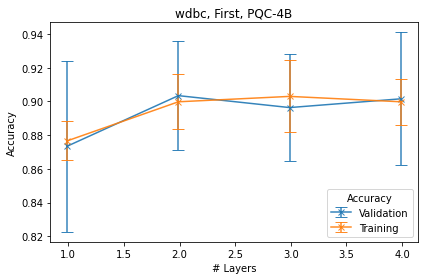

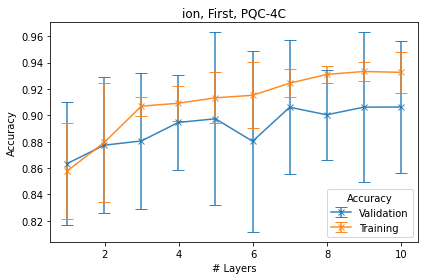

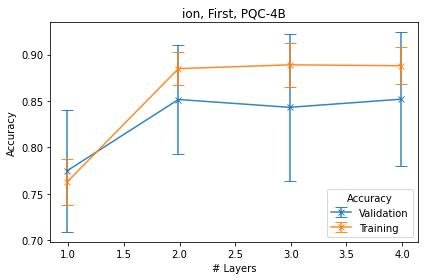

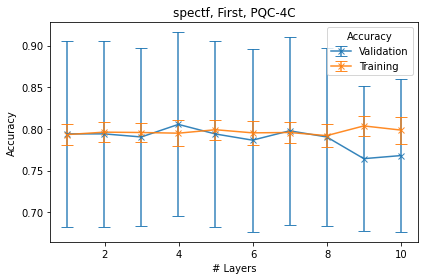

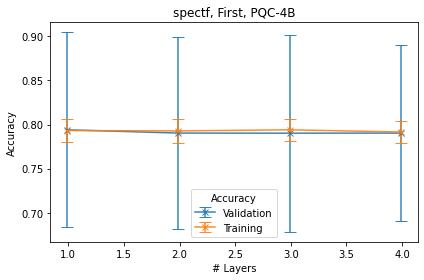

In [29]:
models = ["PQC-4C", "PQC-4B"] #Only include datareuploading models here
datasets = ["wdbc", "ion", "spectf"]
observs = ["First"]
line_types = ["--", "-."]

def mod_label(model):
    if model == "PQC-4B":
        return True
    elif model == "PQC-4C":
        return False

for d in datasets:
    for j, MOD in enumerate(models):  
        #print(MOD)
        for k, o in enumerate(observs):
            layrs_found = []
            mean_v_acc = []
            mean_v_std = []
            mean_t_acc = []
            mean_t_std = []
            for layer in range(1,11):
                fname = f"runs/Exp15*{d}-*{MOD}-{layer}-2-5-{o}*.pkl"
                files = glob.glob(fname)
                v_acc = np.zeros((len(files)))
                t_acc = np.zeros((len(files)))
                if len(files) >= 1:
                    for i, f in enumerate(files):
                        pickle_open = open(f, 'rb')
                        run_dict = pickle.load(pickle_open)
                        pickle_open.close()
                        v_acc[i] = run_dict["validation_accuracy"][-1]
                        t_acc[i] = run_dict["training_acc"][-1]

                    mean_v_std.append(np.std(v_acc))
                    mean_v_acc.append(np.mean(v_acc))
                    mean_t_std.append(np.std(t_acc))
                    mean_t_acc.append(np.mean(t_acc))
                    layrs_found.append(layer)

            plt.errorbar(np.array(layrs_found)-0.01, mean_v_acc, yerr=mean_v_std, fmt="x-", label="Validation",
                         alpha=0.9, capsize=6)
            plt.errorbar(np.array(layrs_found)-0.01, mean_t_acc, yerr=mean_t_std, fmt="x-", label="Training",
                         alpha=0.9, capsize=6)

            plt.xlabel("# Layers")
            plt.ylabel("Accuracy")
            plt.title(f"{d}, {o}, {MOD}")
            plt.tight_layout()
            plt.legend(title="Accuracy")

            plt.show()

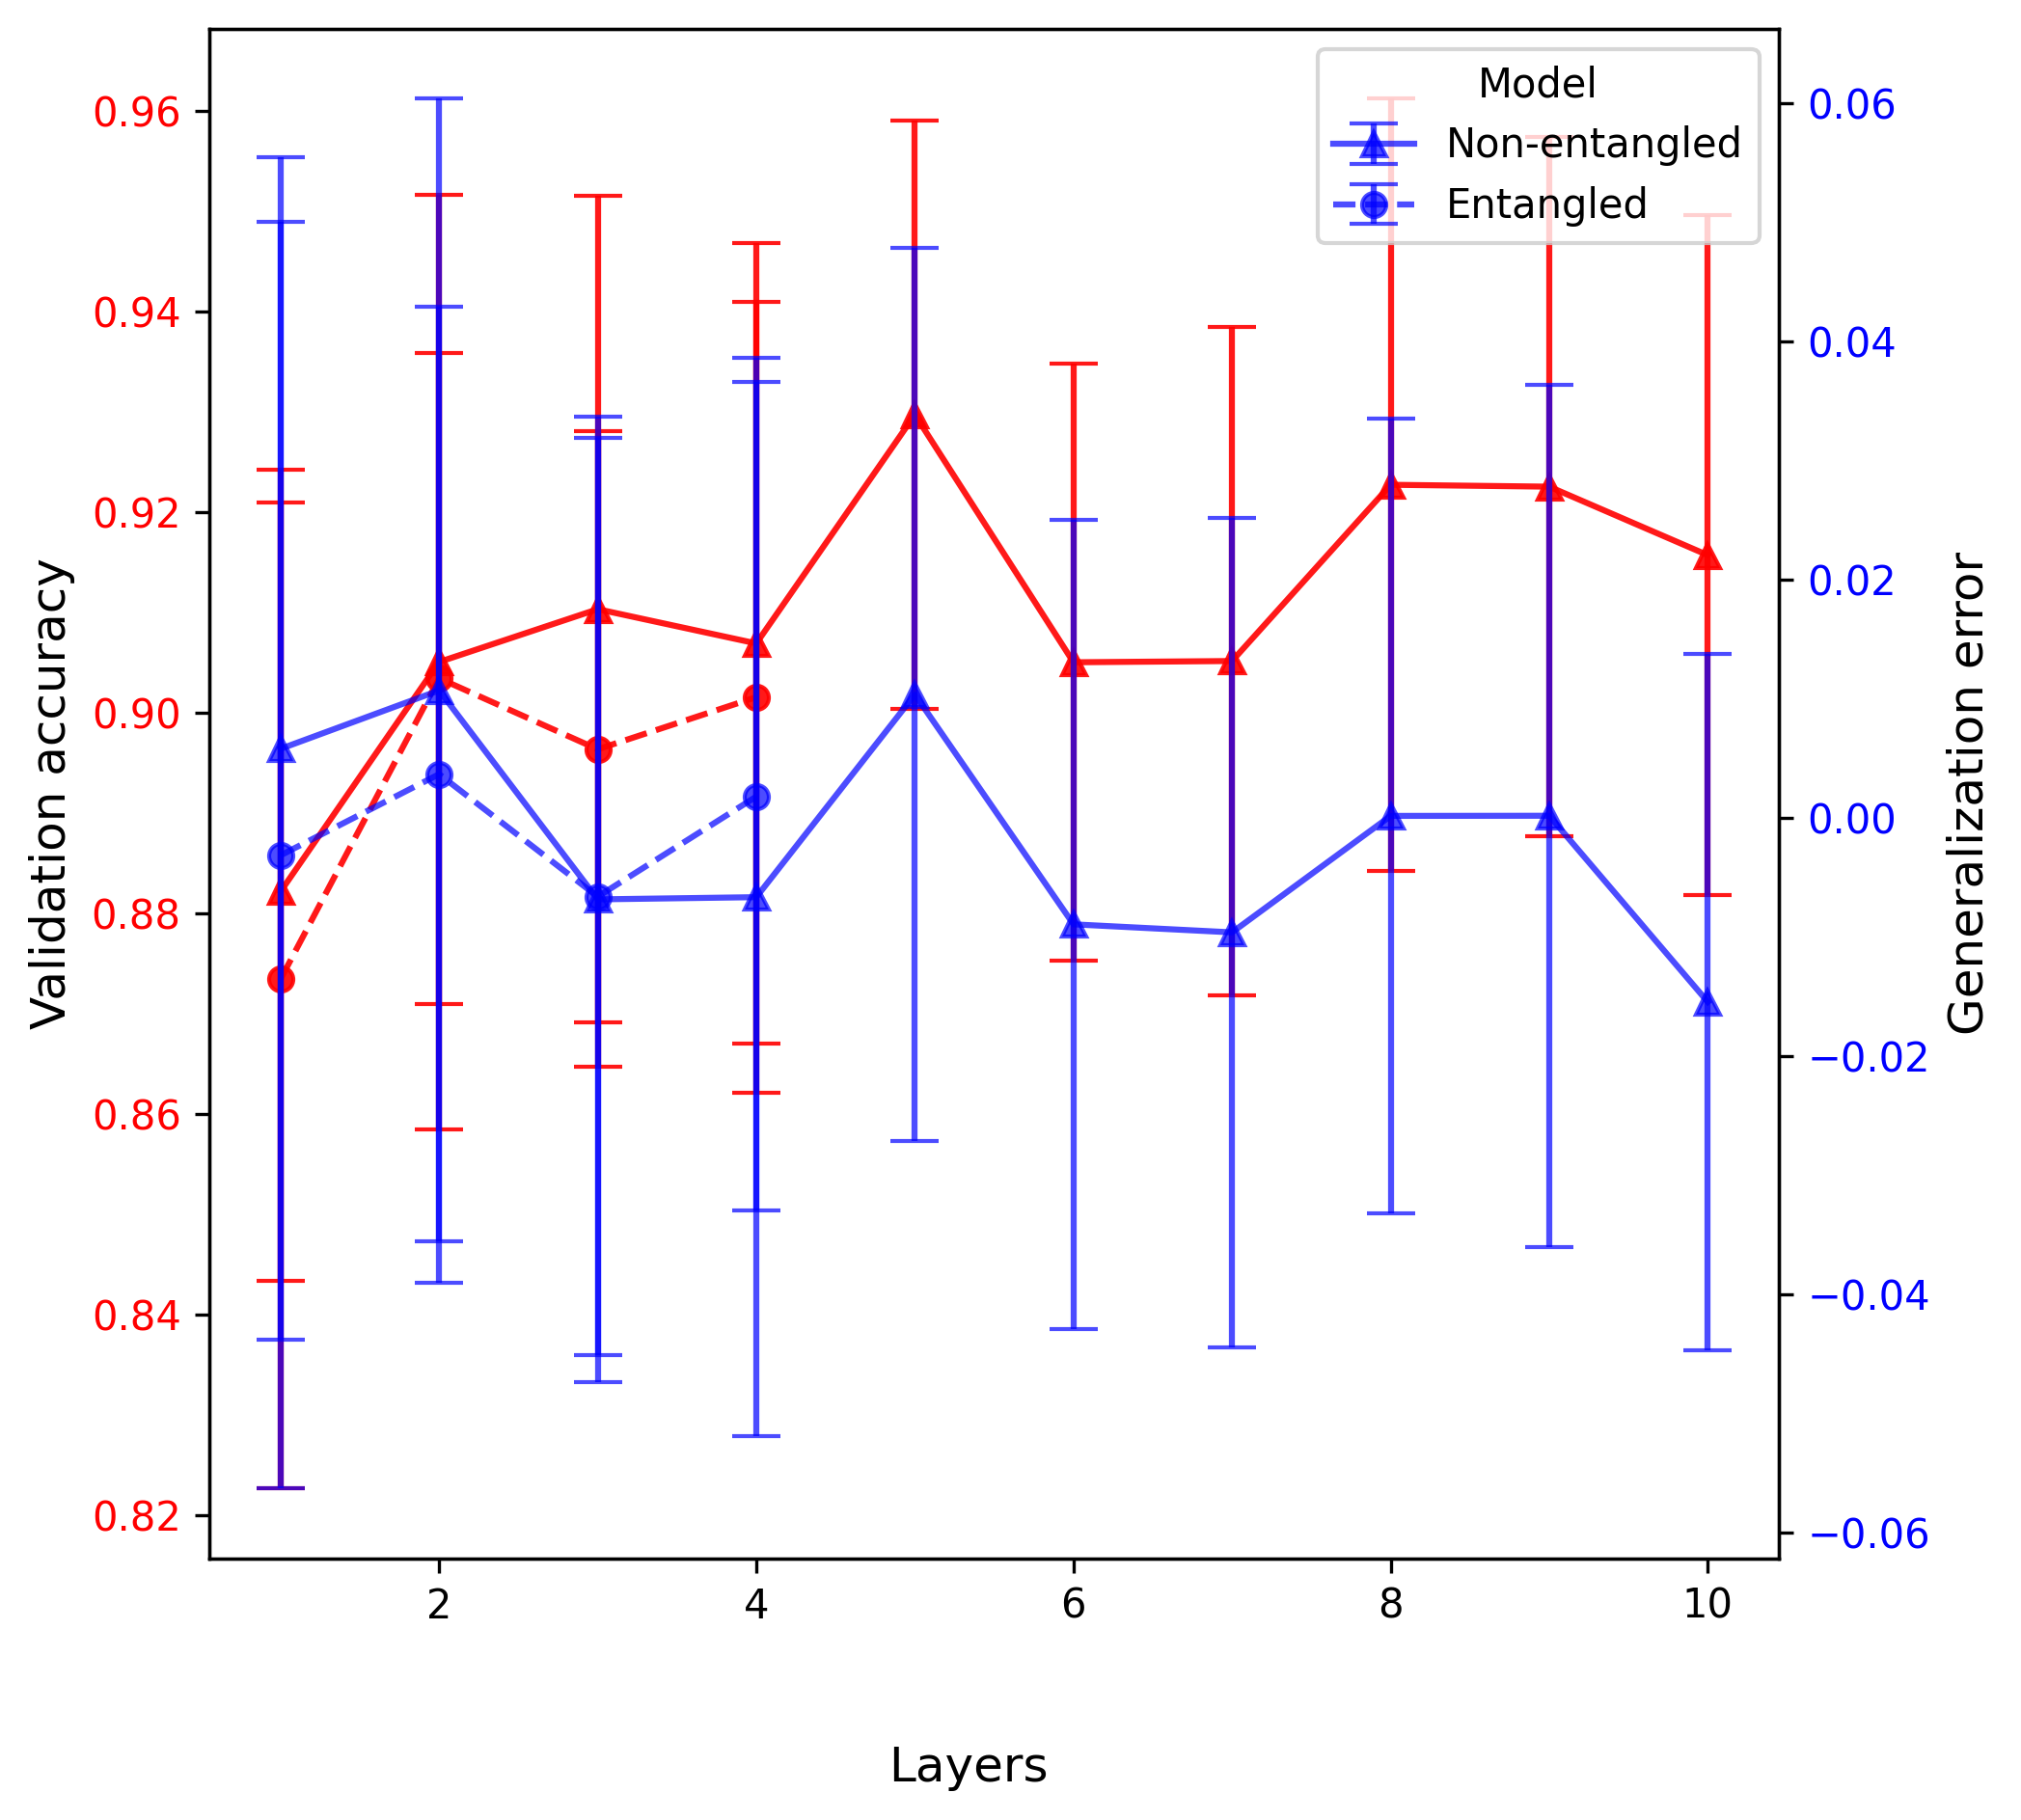

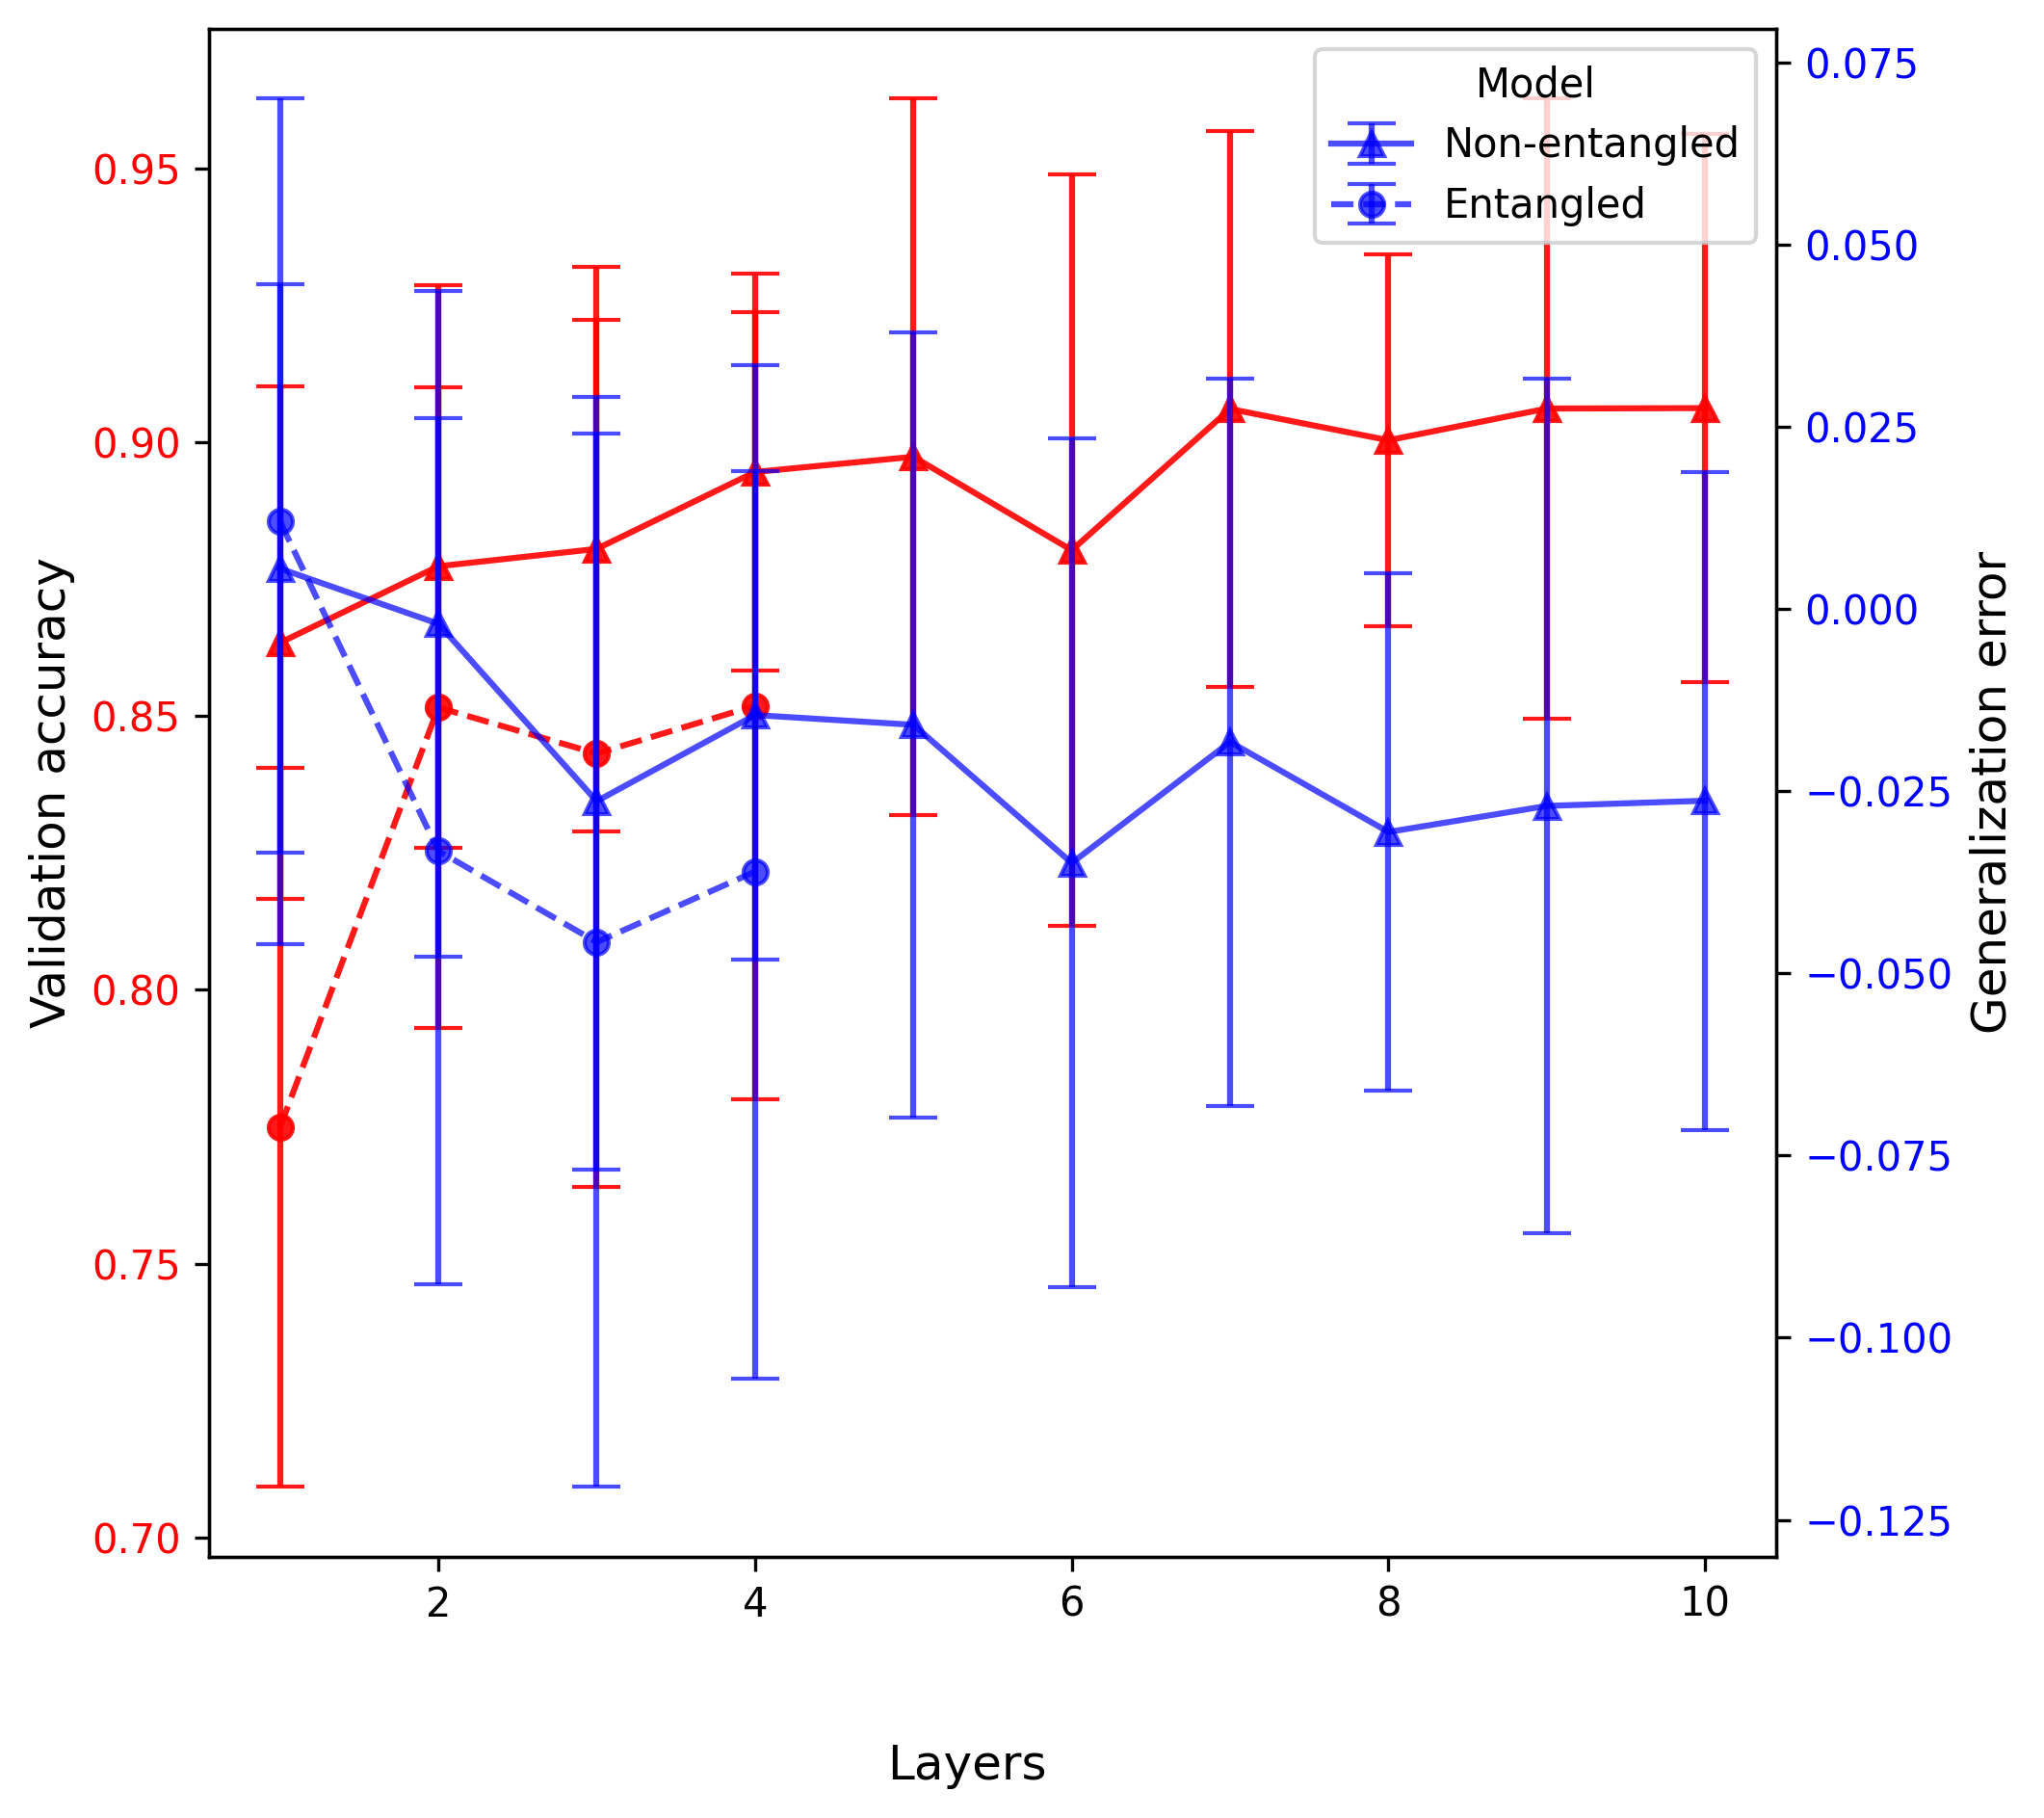

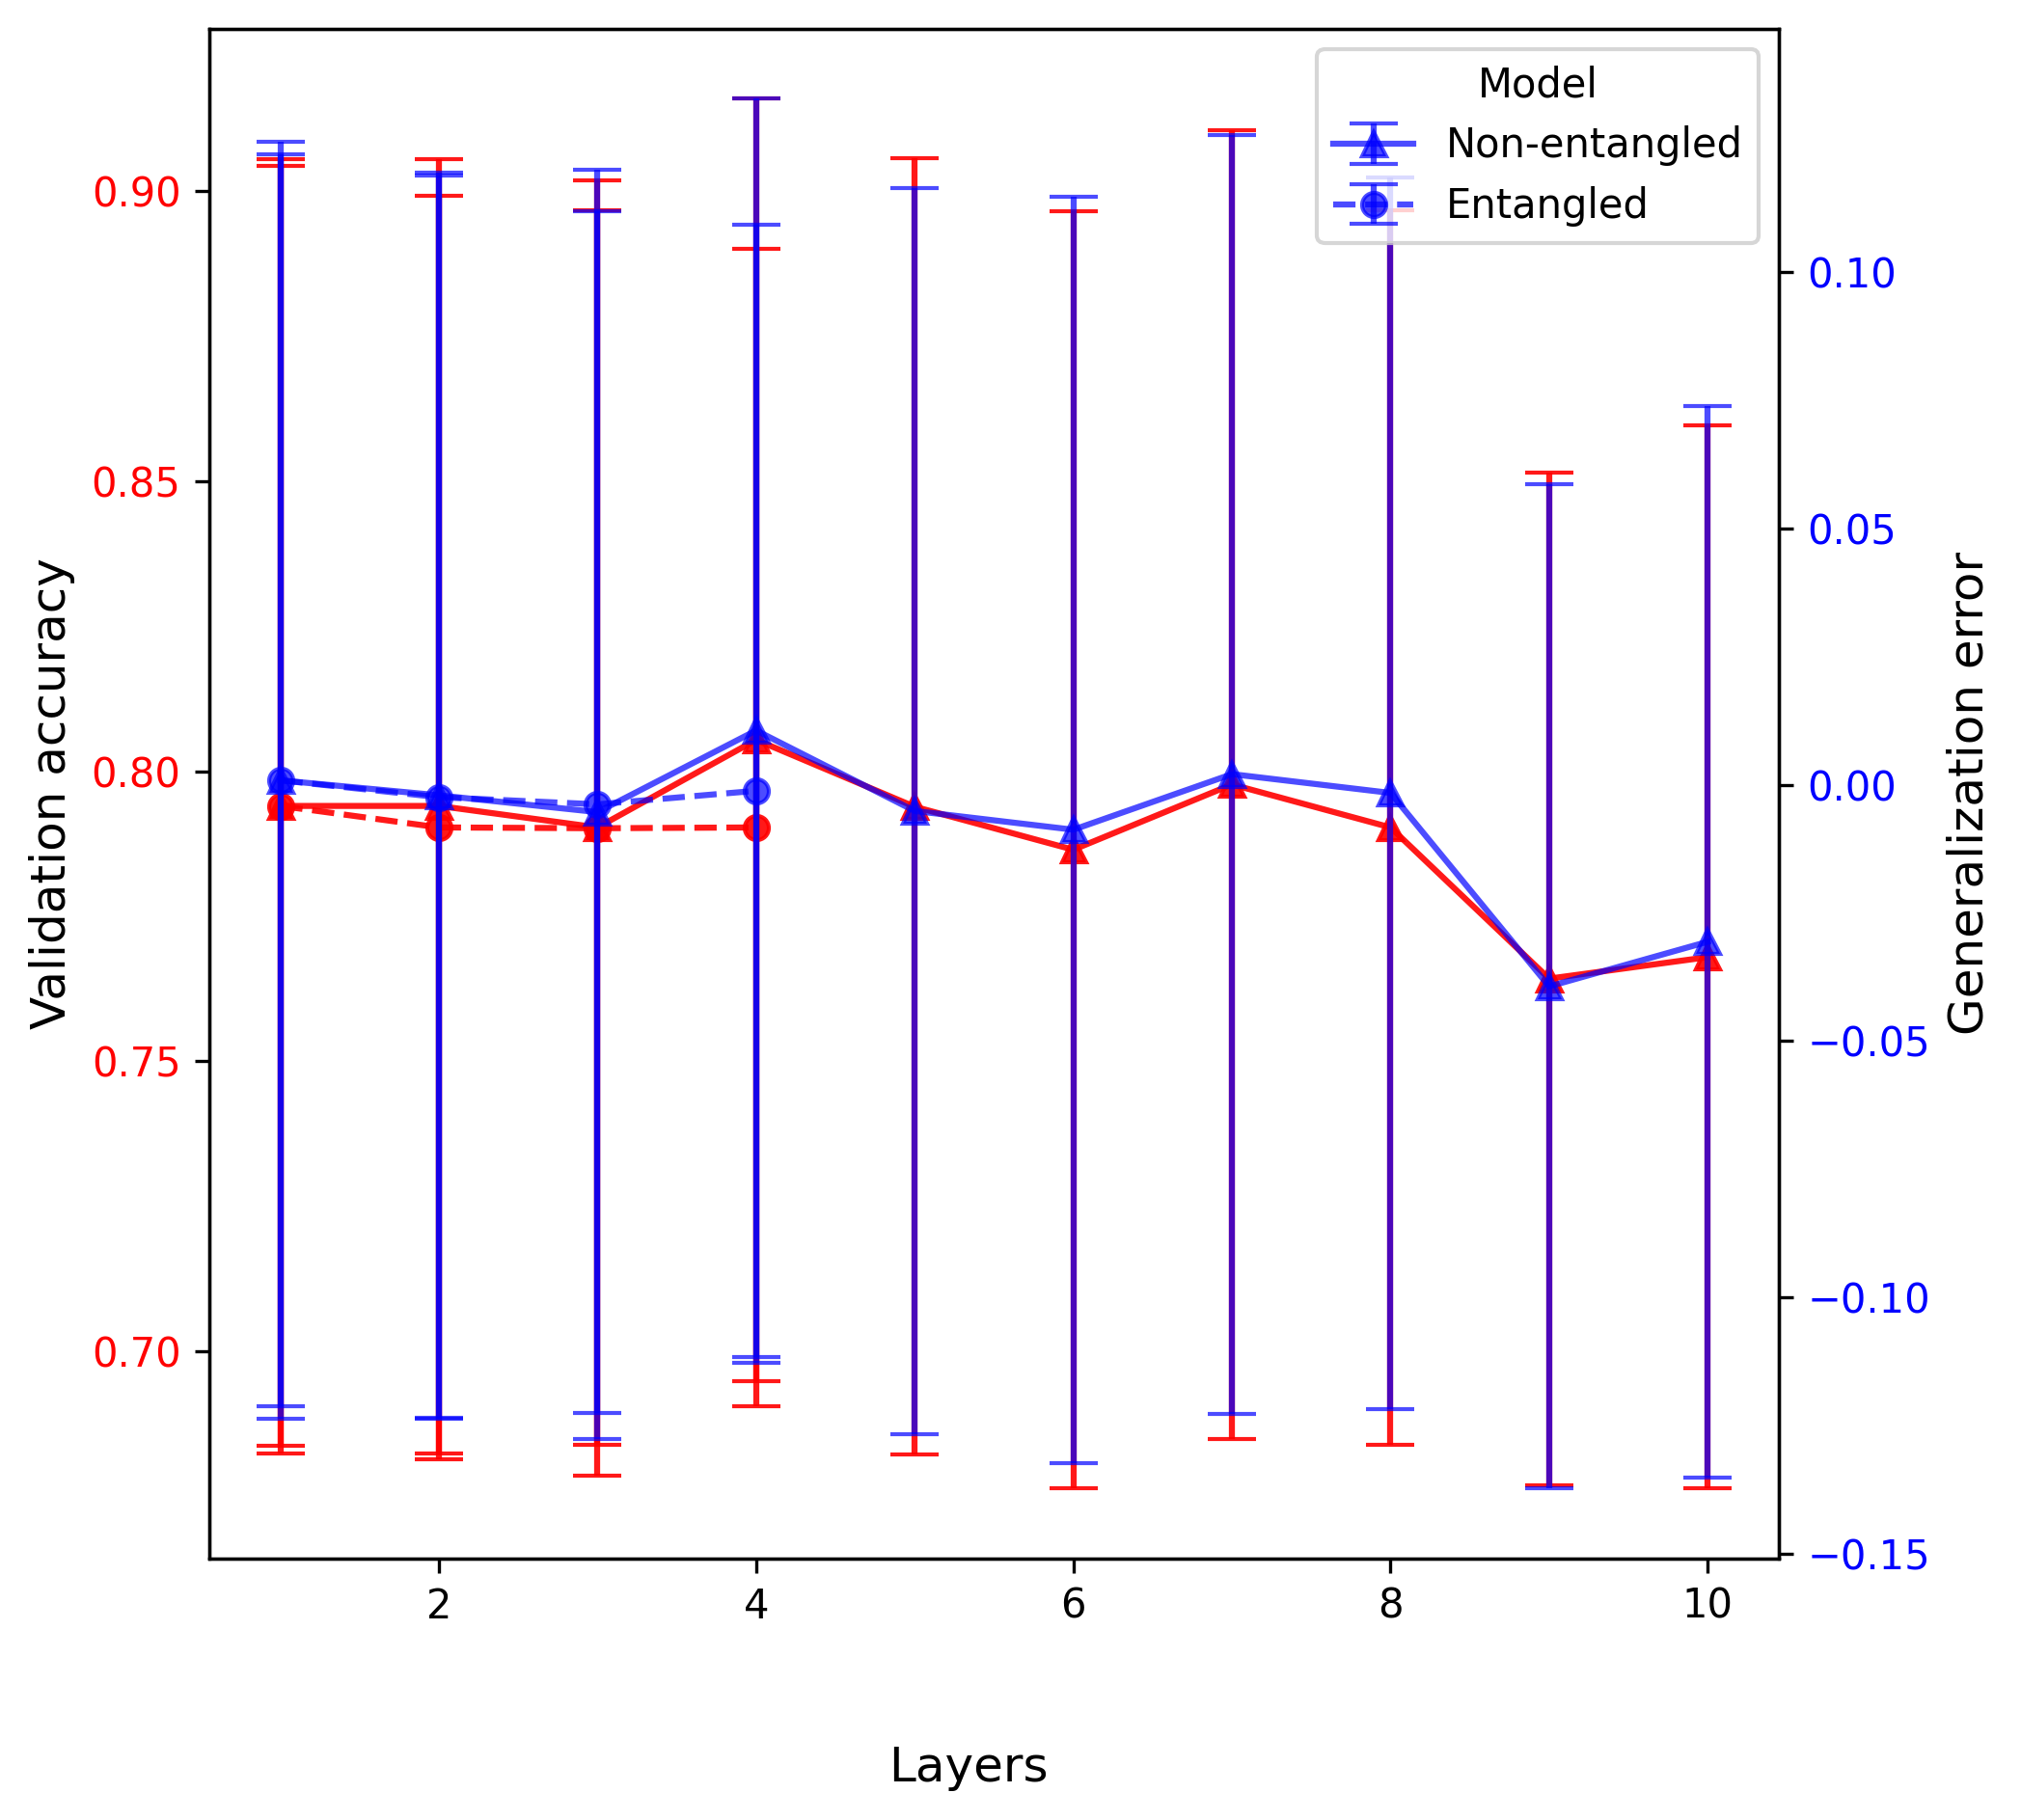

In [11]:
models = ["PQC-4C", "PQC-4B"]
datasets = ["wdbc", "ion", "spectf"]
Dnames = ["WDBC", "ION", "SPECTF"]
line_types = ["--", "-."]
cls = ["b", "r"]
clsl = ["^-", "o--"]

def mod_label(m):
    if m == "PQC-4B":
        return "Entangled"
    else:
        return "Non-entangled"


for q, d in enumerate(datasets):
    fig1, ax1 = plt.subplots(figsize=(7,7), dpi=300)
    ax2 = ax1.twinx()
    ax1.set_ylabel("Validation accuracy", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="r")
    ax2.set_ylabel("Generalization error", fontsize=12)   
    ax2.tick_params(axis="y", labelcolor="b")
    fig1.supxlabel("Layers")
    for j, MOD in enumerate(models):  
        layrs_found = []
        mean_v_acc = []
        mean_v_std = []
        mean_g_err = []
        mean_g_std = []
        for layer in range(1,11):
            fname = f"runs/Exp15*{d}-*{MOD}-{layer}-2-5-First*.pkl"
            files = glob.glob(fname)
            v_acc = np.zeros((len(files)))
            t_acc = np.zeros((len(files)))
            if len(files) >= 1:
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    pickle_open.close()
                    v_acc[i] = run_dict["validation_accuracy"][-1]
                    t_acc[i] = run_dict["training_acc"][-1]

                mean_v_std.append(np.std(v_acc))
                mean_v_acc.append(np.mean(v_acc))
                mean_g_std.append(np.std(v_acc-t_acc))
                mean_g_err.append(np.mean(v_acc-t_acc))
                layrs_found.append(layer)
        mean_v_std = np.array(mean_v_std)
        mean_v_acc = np.array(mean_v_acc)


        ax1.errorbar(np.array(layrs_found), mean_v_acc, yerr=mean_v_std, fmt="r"+clsl[j], label=mod_label(MOD),
                     alpha=0.9, capsize=6)
        ax2.errorbar(np.array(layrs_found), mean_g_err, yerr=mean_g_std, fmt="b"+clsl[j], label=mod_label(MOD),
                     alpha=0.7, capsize=6)


    plt.legend(title="Model")
    plt.show()

For the Ising model we take the critical transverse field Ising Hamiltonian $H = \sum_{j}^{N-1}Z_{j}Z_{j+1} + \sum_{i}^{N} X_{i}$ to perform a regression task. We simulate the Hamiltonian using the Lie/Trotter product formula $exp(-i\sum_{j}^{m}H_{j}t) = (\prod^{m}_{j} exp(-iH_{j}t/n))^{n}$. The following parameters are used: $N=10, t/n=0.08$, with an all-zero fiducial state. The data feature is time, and the output is a Pauli Z observable on the first qubit. We obtain the output as follows:
The simulation is run for 3750 timesteps (ie for t=300) and discard all data apart from the wavefunction.
For each subsequent timestep, we evolve the wavefunction as before, after which we record the $\langle Z \rangle$ of the first qubit. This is repeated for 100 timesteps (ie from t=300 to t=308).

We map the input data (time) from the range [300, 308] to [-$\pi$, $\pi$]. The model is our standard ansatz with two layers. We compare two models based on the presence of inter-block entanglement.

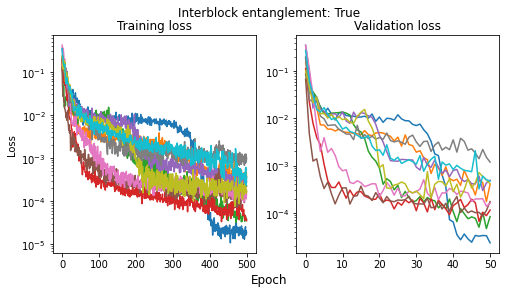

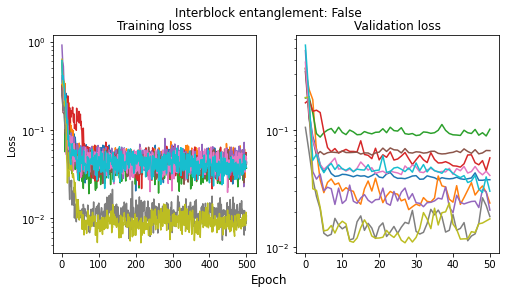

1 qubits. Loss x 10^4:


Entangled        Non-entangled
Training    2.680$\pm$2.759  354.784$\pm$130.409
Validation  3.520$\pm$3.232  415.491$\pm$256.136

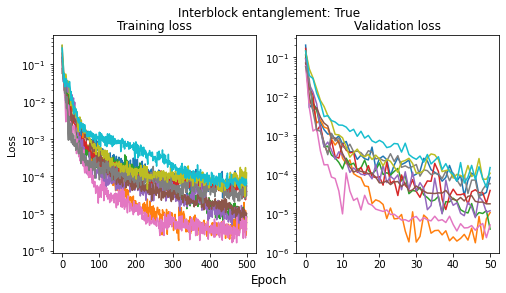

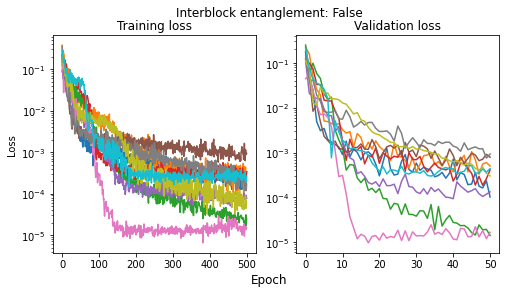

2 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.344$\pm$0.354  2.406$\pm$2.562
Validation  0.485$\pm$0.475  3.643$\pm$2.997

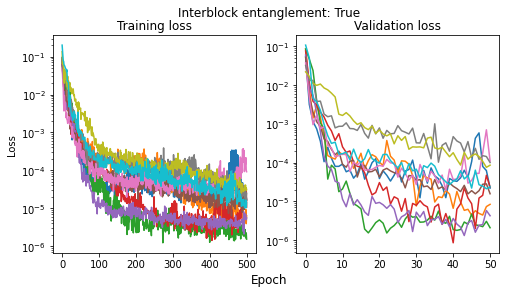

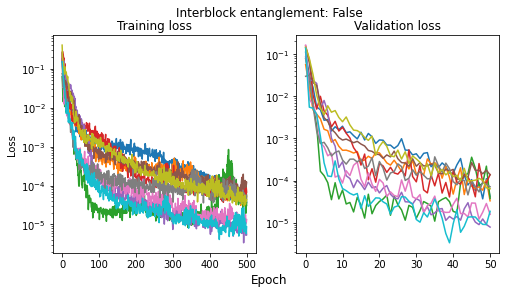

3 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.219$\pm$0.248  0.435$\pm$0.324
Validation  0.393$\pm$0.396  0.565$\pm$0.448

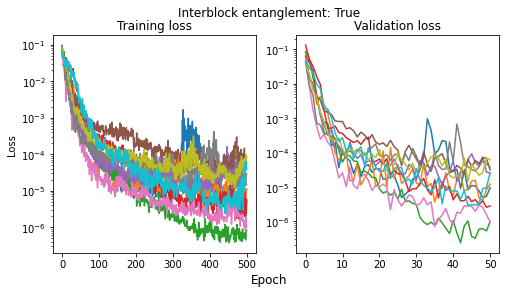

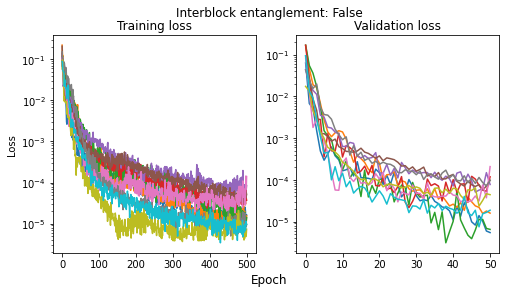

4 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.250$\pm$0.268  0.383$\pm$0.409
Validation  0.209$\pm$0.186  0.689$\pm$0.611

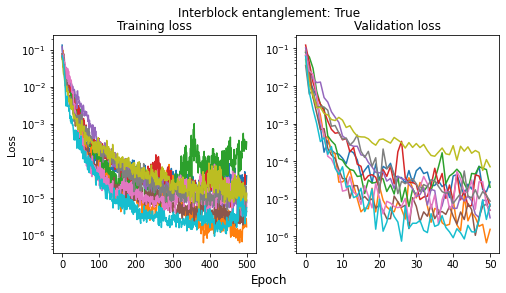

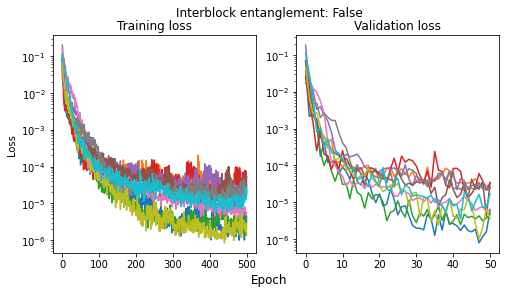

5 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.109$\pm$0.106  0.184$\pm$0.151
Validation  0.151$\pm$0.211  0.177$\pm$0.113

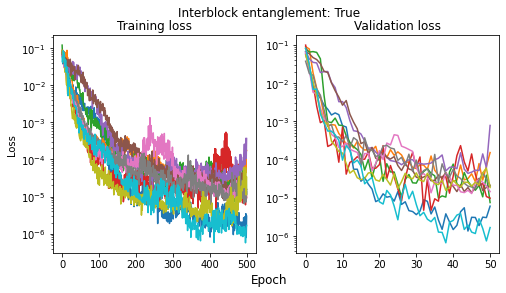

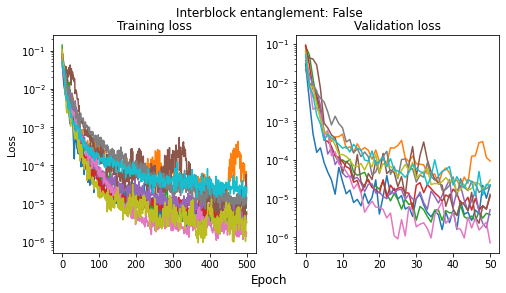

6 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.302$\pm$0.516  0.150$\pm$0.143
Validation  0.278$\pm$0.442  0.222$\pm$0.253

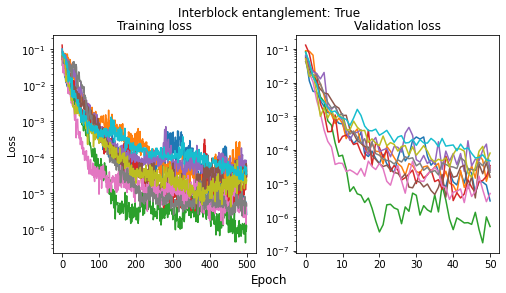

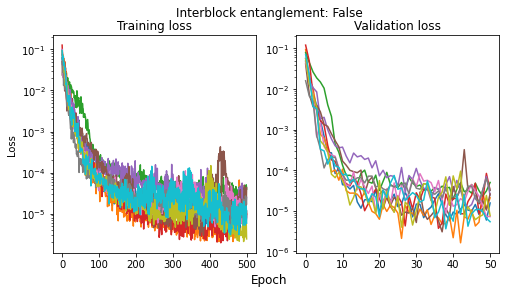

7 qubits. Loss x 10^4:


Entangled    Non-entangled
Training    0.232$\pm$0.185  0.172$\pm$0.135
Validation  0.261$\pm$0.228  0.220$\pm$0.132

In [21]:
datasets = ["ising-10"]
models = ["PQC-4B", "PQC-4C"]
loss_tab = np.zeros((2,2))
lstd_tab = np.zeros((2,2))

def mod_label(model):
    if model == "PQC-4B":
        return True
    elif model == "PQC-4C":
        return False

best_n, naem_n = np.zeros((4,7)), np.zeros((4,7))


for q in range(1,8):
    loss_tab = np.zeros((2,2))
    lstd_tab = np.zeros((2,2))
    for d in datasets:
        for p, m in enumerate(models):
            fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
            fig1.suptitle(f"Interblock entanglement: {mod_label(m)}")
            ax[0].set_ylabel("Loss")
            fig1.supxlabel("Epoch")
            ax[0].set_title(f"Training loss")
            ax[1].set_title(f"Validation loss")
            fname = f"runs/Exp18*{d}-*-{m}-2-2-{q}-0,0*.pkl"
            files = glob.glob(fname)
            if len(files) > 0:
                v_accs = np.zeros((len(files), 1))
                t_accs = np.zeros((len(files), 1))
                for i, f in enumerate(files):
                    pickle_open = open(f, 'rb')
                    run_dict = pickle.load(pickle_open)
                    v_accs[i] = run_dict["validation_loss"][-1]
                    t_accs[i] = run_dict["training_loss"][-1]
                    ax[0].semilogy(run_dict["training_loss"])
                    ax[1].semilogy(run_dict["validation_loss"])

                if q in [5,6] and m == "PQC-4B":
                    idx = np.argmax(t_accs)
                    v_accs = v_accs[np.array([i for i in range(len(files)) if i!=idx])]
                    t_accs = t_accs[np.array([i for i in range(len(files)) if i!=idx])]
                loss_tab[p,0] = np.mean(t_accs)
                loss_tab[p,1] = np.mean(v_accs)
                lstd_tab[p,0] = np.std(t_accs)
                lstd_tab[p,1] = np.std(v_accs)
            plt.show()
            best_n[p,q-1] = np.min(v_accs)
            naem_n[p,q-1] = np.mean(v_accs)
            best_n[p+2,q-1] = np.min(t_accs)
            naem_n[p+2,q-1] = np.mean(t_accs)
                       

    loss_tab *= 10000
    lstd_tab *= 10000

    df = pd.DataFrame({"Entangled":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(loss_tab[0], lstd_tab[0])],
                       "Non-entangled":[f"{acc:.3f}$\pm${std:.3f}" for acc, std in zip(loss_tab[1], lstd_tab[1])]},
                      index=["Training", "Validation"])

    print(f"{q} qubits. Loss x 10^4:")
    display(df)

Text(0.0, 1.0, '$\\bf{B}$. Non-entangled model')

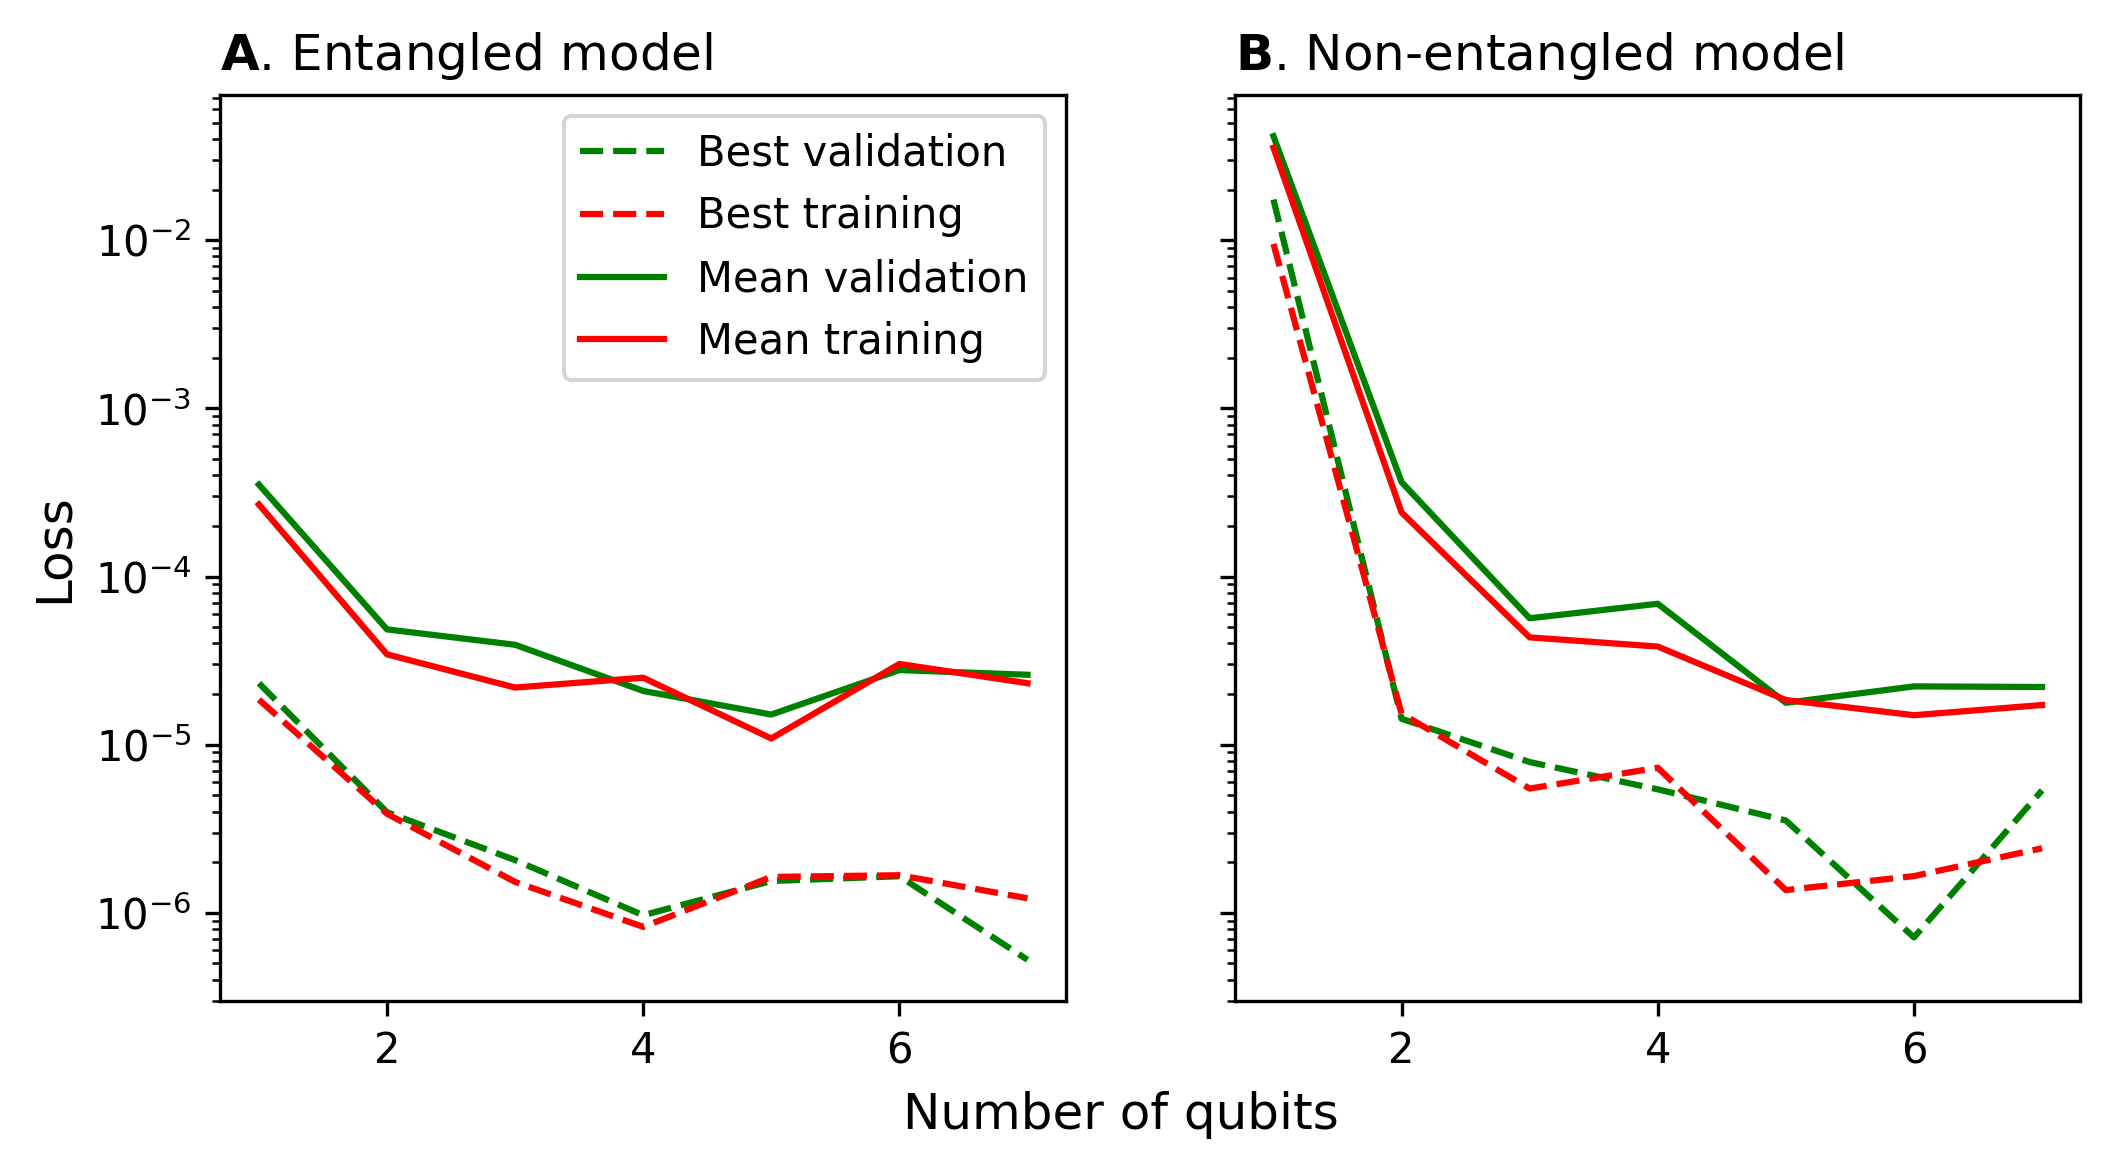

In [20]:
fig_, ax_ = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,4), dpi=300)
ax_[0].semilogy(np.arange(1,8), best_n[0], "g--", label="Best validation")
ax_[1].semilogy(np.arange(1,8), best_n[1], "g--")
ax_[0].semilogy(np.arange(1,8), best_n[2], "r--", label="Best training")
ax_[1].semilogy(np.arange(1,8), best_n[3], "r--")
ax_[0].semilogy(np.arange(1,8), naem_n[0], "g-", label="Mean validation")
ax_[1].semilogy(np.arange(1,8), naem_n[1], "g-")
ax_[0].semilogy(np.arange(1,8), naem_n[2], "r-", label="Mean training")
ax_[1].semilogy(np.arange(1,8), naem_n[3], "r-")
#ax_[0].plot([],[], "k--", label="Best")
#ax_[0].plot([],[], "k-", label="Mean")
#ax_[0].plot([],[], "g-.", label="Validation")
#ax_[0].plot([],[], "r-.", label="Training")
ax_[0].legend()
fig_.supxlabel("Number of qubits", fontsize=12)
ax_[0].set_ylabel("Loss", fontsize=12)
ax_[0].set_title(r"$\bf{A}$. Entangled model", loc="left", fontsize=12)
ax_[1].set_title(r"$\bf{B}$. Non-entangled model", loc="left", fontsize=12)

The variance in the dataset targets is 0.055 which is higher than the losses posted above (consider the factor of 10,000) which suggests the models are learning the dynamics, rather than just the output distribution as with the PQC output task.

0.8515873015873016
0.8773809523809524


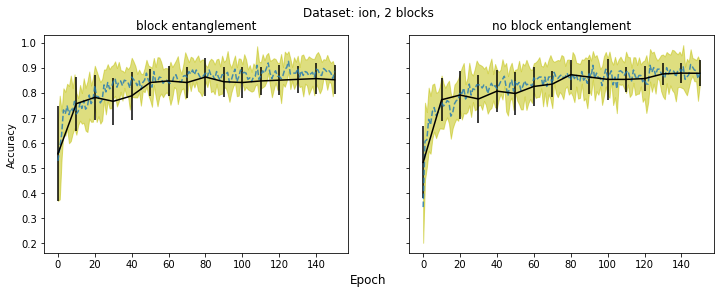

0.8230158730158731
0.8318253968253968


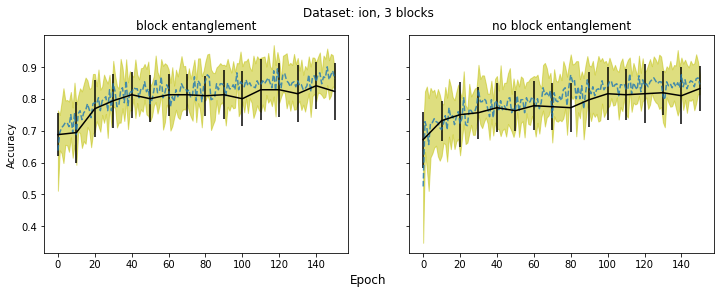

0.811984126984127
0.8005555555555557


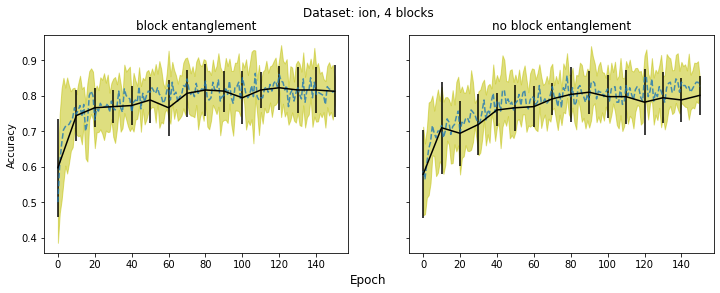

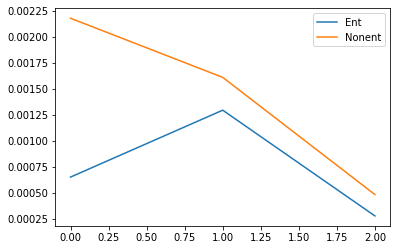

In [18]:
colors = ["b", "g", "r", "k"]
models = ["PQC-4B", "PQC-4C"]

 
def label_ent(mod):
    if mod[-1] == "B":
        return "block entanglement"
    else:
        return "no block entanglement"

command_train = None

v_x_range = np.arange(0,151, 10)
t_x_range = np.arange(0,151)
#b, q fixed, l is over range [2,3,4]
grad1b, grad2b, grad1c, grad2c = [], [], [], []
for b in range(2,5):
    fig1, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
    fig1.suptitle(f"Dataset: ion, {b} blocks")
    ax[0].set_ylabel("Accuracy")
    fig1.supxlabel("Epoch")
    for j, m in enumerate(models):
        v_acc_mean, v_acc_std = [], []
        t_acc_mean, t_acc_std = [], []
        fname = f"runs/Exp1*ion*{m}-2-{b}-5-First*.pkl"
        files = glob.glob(fname)
        if len(files) >= 1:
            v_accs = np.zeros((len(files), 16))
            t_accs = np.zeros((len(files), 151))
            g1, g2 = [], []
            for i, f in enumerate(files):
                pickle_open = open(f, 'rb')
                run_dict = pickle.load(pickle_open)
                v_accs[i] = run_dict["validation_accuracy"]
                t_accs[i] = run_dict["training_acc"]
                g1.append(np.std(run_dict["gradient1"]))
                g2.append(np.std(run_dict["gradient2"]))
                
            print(np.mean(v_accs[:,-1]))
            ax[j].set_title(f"{label_ent(m)}")
            ax[j].errorbar(v_x_range, np.mean(v_accs, axis=0), yerr=np.std(v_accs, axis=0), fmt="k-")
            #ax[j].errorbar(t_x_range[1::2], np.mean(t_accs, axis=0)[1::2], yerr=np.std(t_accs, axis=0)[1::2], fmt=colors[j]+"--", alpha=0.6)
            ax[j].plot(t_x_range, np.mean(t_accs, axis=0), "--", alpha=0.8)
            ax[j].fill_between(t_x_range, np.mean(t_accs, axis=0)-np.std(t_accs, axis=0), np.mean(t_accs, axis=0)+np.std(t_accs, axis=0), color="y", alpha=0.5)
            if j == 0:
                grad1b.append(np.mean(g1))
                grad2b.append(np.mean(g2))                    
            elif j == 1:
                grad1c.append(np.mean(g1))
                grad2c.append(np.mean(g2))
    plt.show()
    
    
plt.plot(grad1b, label="Ent")
plt.plot(grad1c, label="Nonent")
plt.legend()